# Predictive Models for GHG Scope 1

In this notebook, we present the four predictive models we worked on.

## Feauture Engineering

Before coding the models, we will create two new variables in our dataset. 

1. Missing_GHG - Boolean indicating if the stock had a missing value in that year (1 = True / 0 = False)
2. Utilities - Boolean indicating if it is a Utility company (1 = True / 0 = False)
3. Time Trend - Cumulative value (0,1,2,3) for each year the stock is in the dataset.

The second variable will be used in the Model #3 and #4

Also, we will create a function to help us apply the k-fold cross validations to any number of splits and to whichever model.

#### Missing_GHG

In [536]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_val_predict
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.preprocessing import scale, PolynomialFeatures
from sklearn.feature_selection import RFE
from datetime import datetime, date
from mpl_toolkits.mplot3d import Axes3D # Visualize the Data for Multiple Linear Regression
import warnings
import matplotlib as mpl
warnings.filterwarnings('ignore')

stocks = pd.read_csv("/Users/yeet/Documents/GitHub/Predicting-Environmental-and-Social-Actions/Datasets/pilot_stocks.csv")
sectors = pd.read_csv("/Users/yeet/Documents/GitHub/Predicting-Environmental-and-Social-Actions/Datasets/52_tickers_sectors.csv")

stocks['Missing_GHG'] = np.where(stocks['GHG Scope 1'].isna(), 1, 0)
stocks.loc[stocks['GHG Scope 1'].isna(),['GHG Scope 1','Missing_GHG']].head()

,GHG Scope 1,Missing_GHG
0,NaN,1
1,NaN,1
2,NaN,1
3,NaN,1
4,NaN,1


#### Utilities

In [407]:
df = pd.merge(stocks, sectors, how='inner',on='Ticker')
df.drop(columns='Name', inplace=True)
stocks = df.copy()
stocks['Utility'] = np.where(stocks.Sector == 'Utilities',1,0)
stocks.loc[stocks.Sector == 'Utilities',].head()

,Year,Ticker,Environmental Disclosure Score,GHG Scope 1,Total Energy Consumption,Change_in_EDS,Change_in_GHG,Change_in_TEC,Company,Total_Assets,...,Ratio of GHG Emissions to Total Assets,Ratio of GHG Emissions to Total Sales,Ratio of Total Energy Consumption to Total Assets,Ratio of Total Energy Consumption to Total Sales,Profitable,Logarithm_Total_Assets,Logarithm_Total_Sales,Missing_GHG,Sector,Utility
0,2005,AEE,NaN,NaN,NaN,NaN,NaN,NaN,AMEREN CORP,18162.000,...,NaN,NaN,NaN,NaN,True,9.807,8.822,1,Utilities,1
1,2006,AEE,NaN,NaN,NaN,NaN,NaN,NaN,AMEREN CORP,19578.000,...,NaN,NaN,NaN,NaN,True,9.882,8.836,1,Utilities,1
2,2007,AEE,9.700,NaN,NaN,NaN,NaN,NaN,AMEREN CORP,20728.000,...,NaN,NaN,NaN,NaN,True,9.939,8.929,1,Utilities,1
3,2008,AEE,9.700,NaN,NaN,0.000,NaN,NaN,AMEREN CORP,22657.000,...,NaN,NaN,NaN,NaN,True,10.028,8.967,1,Utilities,1
4,2009,AEE,12.400,NaN,NaN,27.835,NaN,NaN,AMEREN CORP,23790.000,...,NaN,NaN,NaN,NaN,True,10.077,8.866,1,Utilities,1


#### Time trend

In [408]:
stocks['time_trend'] = stocks.groupby('Ticker').cumcount()
stocks.loc[stocks.Ticker == 'XOM'].groupby(['Ticker','Year']).head()

,Year,Ticker,Environmental Disclosure Score,GHG Scope 1,Total Energy Consumption,Change_in_EDS,Change_in_GHG,Change_in_TEC,Company,Total_Assets,...,Ratio of GHG Emissions to Total Sales,Ratio of Total Energy Consumption to Total Assets,Ratio of Total Energy Consumption to Total Sales,Profitable,Logarithm_Total_Assets,Logarithm_Total_Sales,Missing_GHG,Sector,Utility,time_trend
765,2005,XOM,NaN,NaN,NaN,NaN,NaN,NaN,EXXON MOBIL CORP,208335.000,...,NaN,NaN,NaN,True,12.247,12.701,1,Energy,0,0
766,2006,XOM,43.800,145500.000,433650.000,NaN,NaN,NaN,EXXON MOBIL CORP,219015.000,...,434.217,1980.001,1294.145,True,12.297,12.722,0,Energy,0,1
767,2007,XOM,46.300,141000.000,430556.000,5.708,-3.093,-0.713,EXXON MOBIL CORP,242082.000,...,393.196,1778.554,1200.658,True,12.397,12.790,0,Energy,0,2
768,2008,XOM,46.300,126000.000,416667.000,0.000,-10.638,-3.226,EXXON MOBIL CORP,228052.000,...,296.421,1827.070,980.229,True,12.337,12.960,0,Energy,0,3
769,2009,XOM,52.900,128000.000,405639.000,14.255,1.587,-2.647,EXXON MOBIL CORP,233323.000,...,464.502,1738.530,1472.032,True,12.360,12.527,0,Energy,0,4
770,2010,XOM,54.600,132000.000,408333.000,3.214,3.125,0.664,EXXON MOBIL CORP,302510.000,...,386.442,1349.817,1195.431,True,12.620,12.741,0,Energy,0,5
771,2011,XOM,54.600,136000.000,430556.000,0.000,3.030,5.442,EXXON MOBIL CORP,331052.000,...,313.707,1300.569,993.149,True,12.710,12.980,0,Energy,0,6
772,2012,XOM,55.400,132000.000,416667.000,1.465,-2.941,-3.226,EXXON MOBIL CORP,333795.000,...,313.752,1248.272,990.381,True,12.718,12.950,0,Energy,0,7
773,2013,XOM,55.400,135000.000,416667.000,0.000,2.273,0.000,EXXON MOBIL CORP,346808.000,...,345.935,1201.434,1067.701,True,12.757,12.875,0,Energy,0,8
774,2014,XOM,55.400,121000.000,444444.000,0.000,-10.370,6.666,EXXON MOBIL CORP,349493.000,...,331.722,1271.682,1218.446,True,12.764,12.807,0,Energy,0,9


### K-fold cross validation function

Below, we created a function called 'kfold_cross_validation' where we send the number of splits, X and y values and the model_type. The function creates the number of k-folds and fits and make predictions for each split. 


At the end, the function returns the Mean Squared error, the Root Mean Square Error and the Coefficient of determination (R2).

In [409]:
def kfold_cross_validation(n_splits, X, y, model_type):
    data_y, data_yhat,coef = [], [],[]
    kfold = KFold(n_splits=n_splits, random_state = 42, shuffle=True)
    for train_ix, test_ix in kfold.split(X):
        # get data
        train_X, test_X = X[train_ix], X[test_ix]
        train_y, test_y = y[train_ix], y[test_ix]
        # fit model
        model = model_type
        model.fit(train_X, train_y)
        # make predictions
        yhat = model.predict(test_X)
            
        coef.append(model.coef_)
        # store
        data_y.extend(test_y)
        data_yhat.extend(yhat)

    # Evaluate the model
    print('Mean squared error: %.2f' % metrics.mean_squared_error(data_y, data_yhat))
    print(f'Root Mean Squared Error: {np.sqrt(metrics.mean_squared_error(data_y, data_yhat))}')
    print('Coefficient of determination: %.2f'% metrics.r2_score(data_y, data_yhat))

## Models

### Model 1 - Sales and Assets


GHG = a + b1*Sales + b2*Assets + e     


In [410]:
df=stocks.copy()
df.columns

Index(['Year', 'Ticker', 'Environmental Disclosure Score', 'GHG Scope 1',
       'Total Energy Consumption', 'Change_in_EDS', 'Change_in_GHG',
       'Change_in_TEC', 'Company', 'Total_Assets', 'Net_Income', 'Total_Sales',
       'Change_in_Sales', 'Change_in_Assets', 'Change_in_NI', 'ROA',
       'Profit_Margin', 'Annual_Stock_Return',
       'Ratio of GHG Emissions to Total Assets',
       'Ratio of GHG Emissions to Total Sales',
       'Ratio of Total Energy Consumption to Total Assets',
       'Ratio of Total Energy Consumption to Total Sales', 'Profitable',
       'Logarithm_Total_Assets', 'Logarithm_Total_Sales', 'Missing_GHG',
       'Sector', 'Utility', 'time_trend'],
      dtype='object')

For this model, the predictors we are interested in are Total Assets and Total Sales and the outcome variable is GHG Scope 1. We will proceed to subset the dataframe to get these columns. 

In [411]:
da=df[['GHG Scope 1','Total_Sales', 'Total_Assets']]

We are now interested in the observations that are not missing GHG Scope. As presented in the previous notebooks, we have a lot of observations missing the GHG Scope 1 value. Therefore, from 780 observations we only get 398 observations. 

In [412]:
dn=da.loc[da['GHG Scope 1'].notna(),  ]
print(f'Now, we have {dn.shape[0]} observations')

Now, we have 398 observations


### Validation set approach - Hold out

Now, we create the X and y variables for the predictors and outcome variable, respectively. Also, we split the dataset into train (80%) and test (20%). 

In [413]:
X = dn.iloc[:, 1:3].values
y = dn.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [414]:
print(f'When we do not include any explanatory variables, the GHG Scope 1 is {round(regressor.intercept_,3)}')

When we do not include any explanatory variables, the GHG Scope 1 is 8051.4


Now, we are going to predict the GHG Scope using the test split. 

In [415]:
y_train_pred = regressor.predict(X_train)
y_pred = regressor.predict(X_test)
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df.head()

,Actual,Predicted
0,3577.300,15212.450
1,119000.000,129202.217
2,3410.000,15292.058
3,14296.500,13591.750
4,32000.000,18793.153


In [416]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 18676.830253094093
Mean Squared Error: 596373921.6269231
Root Mean Squared Error: 24420.76824399517


In [417]:
print('MSE train: %.3f, test: %.3f' % (metrics.mean_squared_error(y_train, y_train_pred),
                metrics.mean_squared_error(y_test, y_pred)))

MSE train: 558753000.262, test: 596373921.627


The model is overfitting, it performs slightly better in train but poorly in test. We can apply other ML techniques to work with the overfitting and play with the Bias-Variance tradeoff in order to get a better accuracy.

In [418]:
r2 =   metrics.r2_score(y_test, y_pred)
print('R^2: {0}'.format(r2))

R^2: 0.5478557801533197


As presented, the MSE is high which means our model isn't great and is overfitting. Moreover, this model explains around 55% of the variance in our dataset. Next, we will create a 3D visualization to present the predictions for this multiple linear regression. 

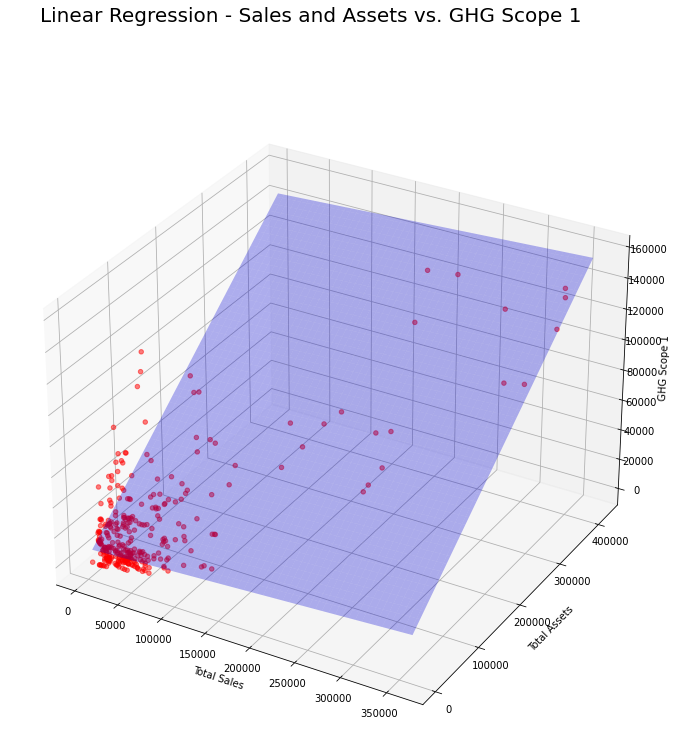

In [419]:
df = pd.DataFrame(X_train ,columns=['Sales','Assets'])
df['GHG_Scope1']= pd.Series(y_train)

x_surf, y_surf = np.meshgrid(np.linspace(df.Assets.min(), df.Assets.max(), 100),np.linspace(df.Sales.min(), df.Sales.max(), 100))

onlyX = pd.DataFrame({'Sales': x_surf.ravel(), 'Assets': y_surf.ravel()})
fittedY= regressor.predict(onlyX)
fittedY=np.array(fittedY)

fig = plt.figure(figsize=(25,12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df.Assets,df.Sales,df.GHG_Scope1,c='red', marker='o', alpha=0.5)
ax.plot_surface(x_surf,y_surf,fittedY.reshape(x_surf.shape), color='b', alpha=0.3)
ax.set_xlabel('Total Sales')
ax.set_ylabel('Total Assets')
ax.set_zlabel('GHG Scope 1')
fig.suptitle('Linear Regression - Sales and Assets vs. GHG Scope 1', fontsize=20);

Also, we can visualize the observed vs predictions to get a better idea of the residuals. 

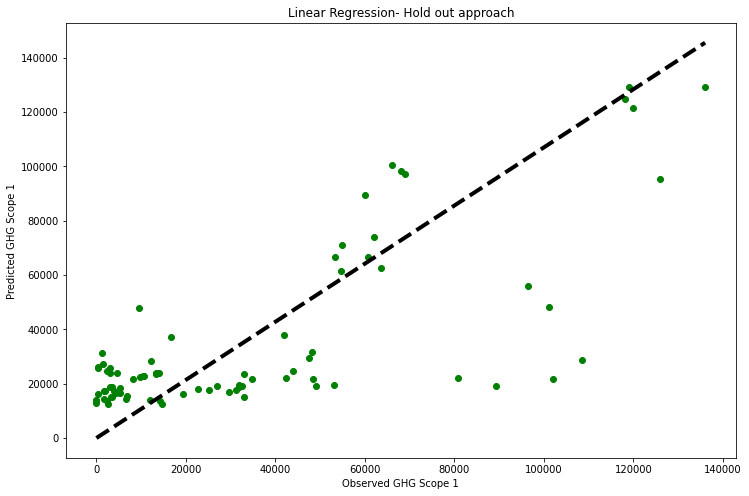

In [420]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(y_test, y_pred, c='green')
ax.plot([y_test.min(), y_test.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Observed GHG Scope 1')
ax.set_ylabel('Predicted GHG Scope 1')
ax.set_title('Linear Regression- Hold out approach');

### K-fold cross validation

Now, we will apply another cross validation technique to improve the model predictions. We first did 10 k-folds and then 5 - k folds

In [421]:
X = dn.iloc[:, 1:3].values
y = dn.iloc[:, 0].values
regressor = LinearRegression()
kfold_cross_validation(10,X,y,regressor)

Mean squared error: 575066434.53
Root Mean Squared Error: 23980.542832273866
Coefficient of determination: 0.46


In [422]:
regressor = LinearRegression()
kfold_cross_validation(5,X,y,regressor)

Mean squared error: 572243005.35
Root Mean Squared Error: 23921.601228835698
Coefficient of determination: 0.46


10 k-fold cross validation presents a higher MSE than 5-fold cross validation. Both of them explained 46% of the variance which is lower than Linear regression - hold out approach. 

We will create a visualization to present the predictions for Linear Regression using 5-kfold cross validation.

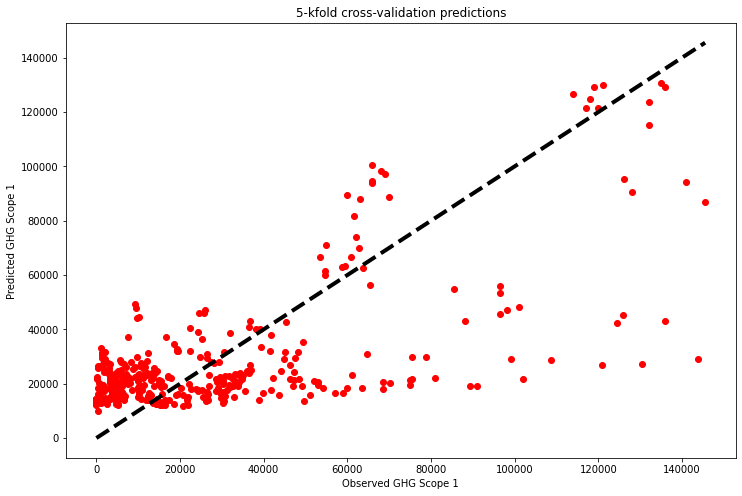

In [423]:
lr = LinearRegression()
X = dn.iloc[:, 1:3].values
y = dn.iloc[:, 0].values
kfold = KFold(n_splits=5, random_state = 42, shuffle=True)
predicted = cross_val_predict(lr, X, y, cv=kfold)

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(y, predicted, c='red')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Observed GHG Scope 1')
ax.set_ylabel('Predicted GHG Scope 1')
ax.set_title('5-kfold cross-validation predictions');

As presented, the model does not fit the data well. The model accounts for 46% of the variance. Let's remember that the more variance that is accounted for by the regression model the closer the data points will fall to the fitted regression line. The visualization presents big residuals between the observed and the fitted values once the GHG scope starts increasing. However, it is able to predict almost accurate some of the hightest values. 

We will proceed to add this results to a dataframe where we can keep track of all the models and their respective MSE. 

In [424]:
df_model_eval = pd.DataFrame({'Model_Number':1,'Model_Name': 'Linear (Sales + Asset)','Approach':'Hold-out','MSE': metrics.mean_squared_error(y_test, y_pred), 'RMSE' :np.sqrt(metrics.mean_squared_error(y_test, y_pred)), 'R-Squared' :  metrics.r2_score(y_test, y_pred)}, index=[0])
df_model_eval.loc[len(df_model_eval.index)] = [2, 'Linear (Sales + Asset)', '5 K-fold', 572243005.35, 23921.601228835698, 0.46] 
df_model_eval

,Model_Number,Model_Name,Approach,MSE,RMSE,R-Squared
0,1,Linear (Sales + Asset),Hold-out,596373921.627,24420.768,0.548
1,2,Linear (Sales + Asset),5 K-fold,572243005.350,23921.601,0.460


### Ridge Regression 

#### Validation set approach (Hold-out)

We started with 100 alphas and instead of arbitrarily choosing alpha, we used cross-validation to choose the tuning parameter alpha. 

In [425]:
n_alphas = 100
alphas = np.logspace(-10, -2, n_alphas)

# Split data into training and test sets
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv.fit(X_train, y_train)

ridge_1 = Ridge(alpha = ridgecv.alpha_, normalize = True)
ridge_1.fit(X_train, y_train)
yhat_ridge = ridge_1.predict(X_test)

# Evaluate the model
print('Mean squared error: %.2f' % metrics.mean_squared_error(y_test, yhat_ridge))
print(f'Root Mean Squared Error: {np.sqrt(metrics.mean_squared_error(y_test, yhat_ridge))}')
print('Coefficient of determination: %.2f'% metrics.r2_score(y_test, yhat_ridge))

Mean squared error: 593708829.45
Root Mean Squared Error: 24366.141045598604
Coefficient of determination: 0.55


The models explains 55% of the variance in the dataset which is higher than the previous model. 

#### K-fold cross validation


Now, we are going to use 5 and 10 k-fold cross validation to try to yield a lower MSE. We continued using the Ridge Regression with the best alpha but now using the K-fold cross validation to fit and predict. 

In [426]:
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv.fit(X,y)
ridge_2 = Ridge(alpha = ridgecv.alpha_, normalize = True)
kfold_cross_validation(5,X,y,ridge_2)

Mean squared error: 572036157.35
Root Mean Squared Error: 23917.27738169578
Coefficient of determination: 0.46


In [427]:
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv.fit(X,y)
ridge_3 = Ridge(alpha = ridgecv.alpha_, normalize = True)
kfold_cross_validation(10,X,y,ridge_3)

Mean squared error: 574765481.16
Root Mean Squared Error: 23974.267061968854
Coefficient of determination: 0.46


In [428]:
df_model_eval.loc[len(df_model_eval.index)] = [3, 'Ridge (Sales + Asset)', 'Hold-out', metrics.mean_squared_error(y_test, yhat_ridge), 
                                               np.sqrt(metrics.mean_squared_error(y_test, yhat_ridge)), metrics.r2_score(y_test, yhat_ridge)]
df_model_eval.loc[len(df_model_eval.index)] = [4, 'Ridge (Sales + Asset)', '5 K-fold', 574765481.16, 23974.267, 0.46] 
df_model_eval

,Model_Number,Model_Name,Approach,MSE,RMSE,R-Squared
0,1,Linear (Sales + Asset),Hold-out,596373921.627,24420.768,0.548
1,2,Linear (Sales + Asset),5 K-fold,572243005.350,23921.601,0.460
2,3,Ridge (Sales + Asset),Hold-out,593708829.454,24366.141,0.550
3,4,Ridge (Sales + Asset),5 K-fold,574765481.160,23974.267,0.460


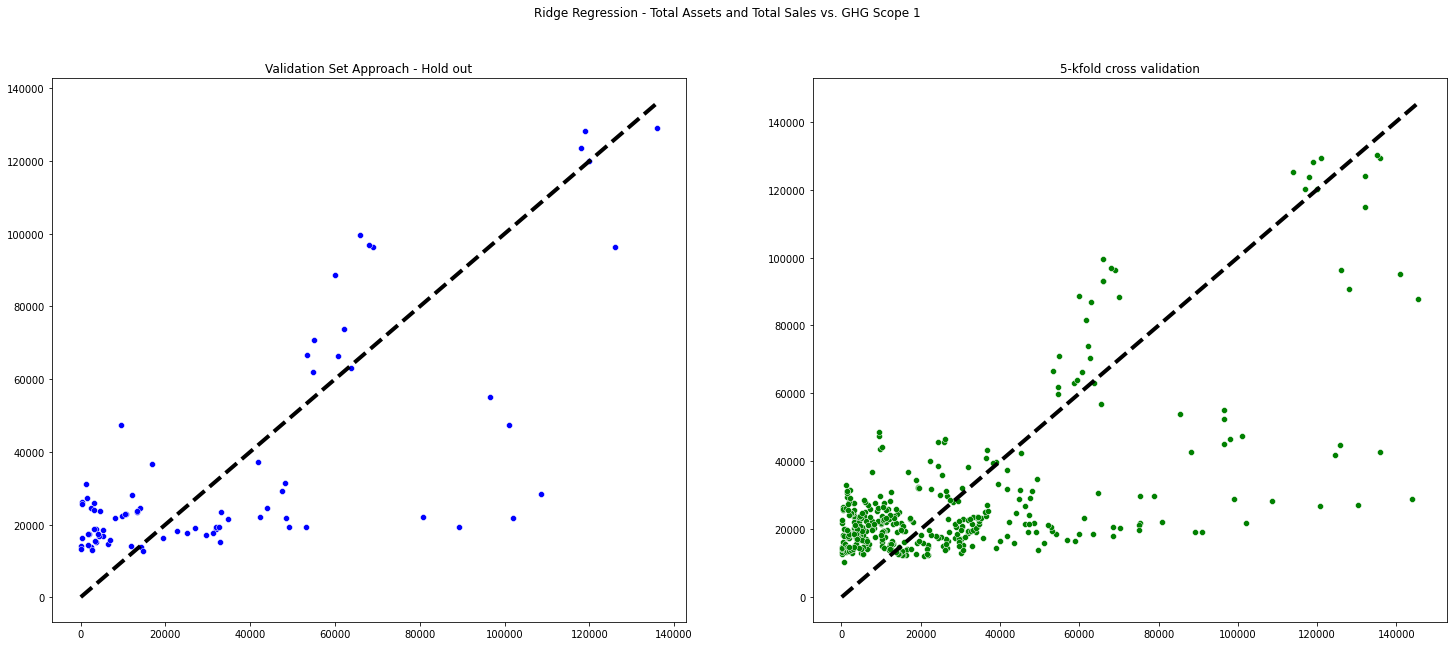

In [429]:
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv.fit(X,y)
ridge_3 = Ridge(alpha = ridgecv.alpha_, normalize = True)
kfold = KFold(n_splits=5, random_state = 42, shuffle=True)
predicted = cross_val_predict(ridge_3, X, y, cv=kfold)

fig, axs = plt.subplots(1,2, figsize=(25,10));
fig.suptitle('Ridge Regression - Total Assets and Total Sales vs. GHG Scope 1');
sns.scatterplot(x=y_test, y = yhat_ridge, ax=axs[0], color='b');
axs[0].set_title('Validation Set Approach - Hold out');
axs[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4);
sns.scatterplot(x=y, y = predicted, ax=axs[1], color='g');
axs[1].set_title('5-kfold cross validation');
axs[1].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4);

Both models don't fit the data well. The model on the left accounts for 55% of the variance and the model on the right accounts for 46% of variance. Again, the more variance that is accounted for by the regression model the closer the data points will fall to the fitted regression line.

We can say that the model on the left is better but we need to take into consideration that it has less data points (Presenting Testing 20% of the data). On the other hand, it presents all the data points and the fitted line. It accounts for less variance but the RMSE decreases too. 

What do we prefer? Validation Set approach because it accounts for more variance and it will behave better with unseen data, right?

Why a flexible model isn't working that well?

### Lasso Regression

#### Validation Set approach - Hold out

First, we will plot the relationship between alpha and the weights (regression parameters), a line for each features. In this case, two (Sales and Assets). 

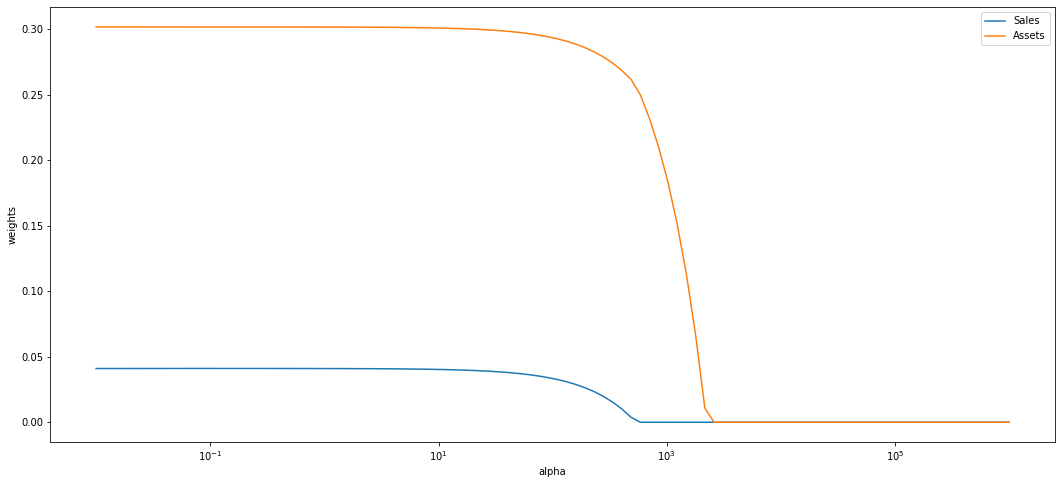

In [430]:
lasso = Lasso(max_iter = 10000, normalize = True)
coefs = []
alphas = 10**np.linspace(6,-2,100)*0.5

X = dn.iloc[:, 1:3].values
y = dn.iloc[:, 0].values

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X, y)
    coefs.append(lasso.coef_)

plt.figure(figsize=(18, 8))
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.legend(['Sales', 'Assets'])
plt.ylabel('weights');

Now, we are going to subset into training and test and calculate the best optimal alpha using cross validation. (Tuning the hyperparameter)

In [431]:
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassocv.fit(X_train, y_train)

print(f'The optimal alpha is {lassocv.alpha_}')

The optimal alpha is 11.532714502900598


In [432]:
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
yhat_lasso = lasso.predict(X_test)

# Evaluate the model
print('Mean squared error: %.2f' % metrics.mean_squared_error(y_test, yhat_lasso))
print(f'Root Mean Squared Error: {np.sqrt(metrics.mean_squared_error(y_test, yhat_lasso))}')
print('Coefficient of determination: %.2f'% metrics.r2_score(y_test, yhat_lasso ))

Mean squared error: 594565957.90
Root Mean Squared Error: 24383.723216524068
Coefficient of determination: 0.55


In [433]:
df_model_eval.loc[len(df_model_eval.index)] = [5, 'Lasso (Sales + Assets)', 'Hold-out',metrics.mean_squared_error(y_test,yhat_lasso), np.sqrt(metrics.mean_squared_error(y_test,yhat_lasso)), metrics.r2_score(y_test, yhat_lasso)] 
df_model_eval

,Model_Number,Model_Name,Approach,MSE,RMSE,R-Squared
0,1,Linear (Sales + Asset),Hold-out,596373921.627,24420.768,0.548
1,2,Linear (Sales + Asset),5 K-fold,572243005.350,23921.601,0.460
2,3,Ridge (Sales + Asset),Hold-out,593708829.454,24366.141,0.550
3,4,Ridge (Sales + Asset),5 K-fold,574765481.160,23974.267,0.460
4,5,Lasso (Sales + Assets),Hold-out,594565957.900,24383.723,0.549


#### K-fold Cross validation approach

Now, we are going to use k folds to fit and predict. We are going to continue using the best optimal alpha.

In [434]:
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassocv.fit(X, y)
lasso = Lasso(max_iter = 10000, normalize = True)
lasso.set_params(alpha=lassocv.alpha_)
kfold_cross_validation(5, X, y, lasso)

Mean squared error: 572586498.50
Root Mean Squared Error: 23928.779711852858
Coefficient of determination: 0.46


In [435]:
lasso = Lasso(max_iter = 10000, normalize = True)
lasso.set_params(alpha=lassocv.alpha_)
kfold_cross_validation(10, X, y, lasso)

Mean squared error: 576170979.17
Root Mean Squared Error: 24003.561801738902
Coefficient of determination: 0.46


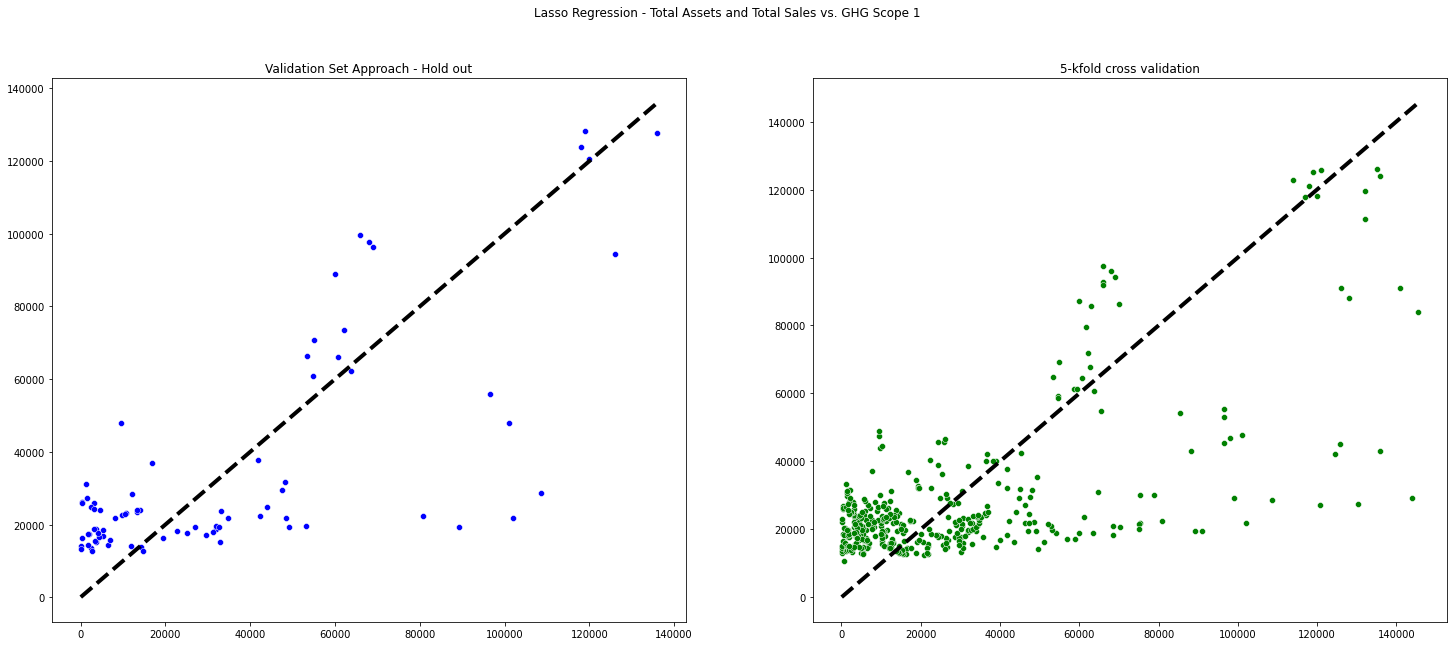

In [436]:
lasso = Lasso(max_iter = 10000, normalize = True)
lasso.set_params(alpha=lassocv.alpha_)
kfold = KFold(n_splits=5, random_state = 42, shuffle=True)
predicted = cross_val_predict(lasso, X, y, cv=kfold)

fig, axs = plt.subplots(1,2, figsize=(25,10));
fig.suptitle('Lasso Regression - Total Assets and Total Sales vs. GHG Scope 1');
sns.scatterplot(x=y_test, y = yhat_lasso, ax=axs[0], color='b');
axs[0].set_title('Validation Set Approach - Hold out');
axs[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4);
sns.scatterplot(x=y, y = predicted, ax=axs[1], color='g');
axs[1].set_title('5-kfold cross validation');
axs[1].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4);

In [437]:
df_model_eval.loc[len(df_model_eval.index)] = [6, 'Lasso (Sales + Assets)', '5 K-fold',572164056.06, 23919.95, 0.46] 
df_model_eval

,Model_Number,Model_Name,Approach,MSE,RMSE,R-Squared
0,1,Linear (Sales + Asset),Hold-out,596373921.627,24420.768,0.548
1,2,Linear (Sales + Asset),5 K-fold,572243005.350,23921.601,0.460
2,3,Ridge (Sales + Asset),Hold-out,593708829.454,24366.141,0.550
3,4,Ridge (Sales + Asset),5 K-fold,574765481.160,23974.267,0.460
4,5,Lasso (Sales + Assets),Hold-out,594565957.900,24383.723,0.549
5,6,Lasso (Sales + Assets),5 K-fold,572164056.060,23919.950,0.460


### Model 2 - Logarithm Sales and Assets

Now, we are going to consider the following formula:

ln(GHG) = a0 + b10*ln(Sales) + b20*ln(Assets) + e

By using the logarithmic values, we are expecting to have a more linear distribution. We are going to apply several Machine learning techniques starting with linear regression. 

### Linear Regression

#### Validation Set Approach - Hold out

We subset 80% to training and 20% to test. 


In [438]:
model_df = stocks[['Total_Sales', 'Total_Assets', 'GHG Scope 1']].copy()
model_df.dropna(inplace = True)

x = np.log(model_df[['Total_Sales', 'Total_Assets']])
y = np.log(model_df['GHG Scope 1'])
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
clf = LinearRegression().fit(X_train, y_train)

y_train_pred = np.exp(clf.predict(X_train))
y_pred = np.exp(clf.predict(X_test))
y_test = np.exp(y_test)

In [439]:
print('MSE train: %.3f, test: %.3f' % (metrics.mean_squared_error(y_train, y_train_pred),
                metrics.mean_squared_error(y_test, y_pred)))

MSE train: 451994269.928, test: 796139917.348


The model is overfitting. We can see a lower MSE for training compared to Train. This means that this model does not behave properly with unseen data. 

In [440]:
#The coefficients
print('Coefficients: \n',clf.coef_)
#Mean Squared Error
print('Mean squared error: %.2f' % metrics.mean_squared_error(y_test,y_pred))
print(f'Root Mean Squared Error: {np.sqrt(metrics.mean_squared_error(y_test,y_pred))}')
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % metrics.r2_score(y_test, y_pred))

Coefficients: 
 [0.10981093 0.73993793]
Mean squared error: 796139917.35
Root Mean Squared Error: 28215.951469835458
Coefficient of determination: 0.40


In [441]:
log_reg = pd.DataFrame({'Observed':y_test,'Prediction':y_pred})
log_reg.head()

,Observed,Prediction
418,3577.300,7113.041
778,119000.000,84476.891
58,3410.000,7266.677
464,14296.500,5567.369
206,32000.000,10140.049


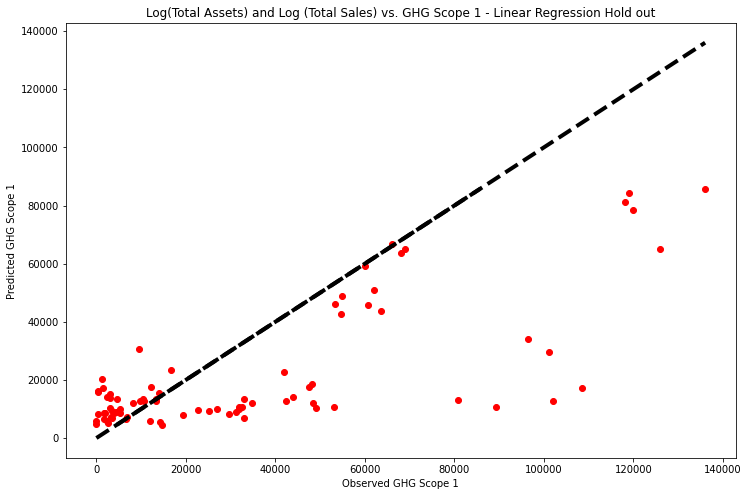

In [442]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(log_reg.Observed, log_reg.Prediction, c='red')
ax.plot([log_reg.min(), log_reg.max()], [log_reg.min(), log_reg.max()], 'k--', lw=4)
ax.set_xlabel('Observed GHG Scope 1')
ax.set_ylabel('Predicted GHG Scope 1')
ax.set_title('Log(Total Assets) and Log (Total Sales) vs. GHG Scope 1 - Linear Regression Hold out');

This model accounts for 40% of the variance. Similar as the other regressions, as soon the GHG Scope starts to increase, the model starts making bad predictions (high bias, way out of target). 

We will proceed to add this results to the dataframe and continue to apply other ML techniques to try to yield a lower MSE. 

In [443]:
df_model_eval.loc[len(df_model_eval.index)] = [7, 'Linear (ln(Sales) + ln(Asset))', 'Hold-out',metrics.mean_squared_error(y_test,y_pred), np.sqrt(metrics.mean_squared_error(y_test,y_pred)), metrics.r2_score(y_test, y_pred)] 
df_model_eval

,Model_Number,Model_Name,Approach,MSE,RMSE,R-Squared
0,1,Linear (Sales + Asset),Hold-out,596373921.627,24420.768,0.548
1,2,Linear (Sales + Asset),5 K-fold,572243005.350,23921.601,0.460
2,3,Ridge (Sales + Asset),Hold-out,593708829.454,24366.141,0.550
3,4,Ridge (Sales + Asset),5 K-fold,574765481.160,23974.267,0.460
4,5,Lasso (Sales + Assets),Hold-out,594565957.900,24383.723,0.549
5,6,Lasso (Sales + Assets),5 K-fold,572164056.060,23919.950,0.460
6,7,Linear (ln(Sales) + ln(Asset)),Hold-out,796139917.348,28215.951,0.396


#### K-fold cross validation

Now, we will apply another cross validation technique to improve the model predictions. First, we will do 5 k-folds and then 10 - k folds. 

In [444]:
df1 = stocks.loc[stocks['GHG Scope 1'].notna(),['GHG Scope 1','Logarithm_Total_Sales','Logarithm_Total_Assets']].copy()
X = df1.iloc[:,1:3].values
y = df1.iloc[:,0].values
regressor = LinearRegression()
kfold_cross_validation(5,X,y,regressor)

Mean squared error: 676789732.54
Root Mean Squared Error: 26015.182731312656
Coefficient of determination: 0.36


In [445]:
X = df1.iloc[:,1:3].values
y = df1.iloc[:,0].values
regressor = LinearRegression()
kfold_cross_validation(10,X,y,regressor)

Mean squared error: 678309215.99
Root Mean Squared Error: 26044.370140028906
Coefficient of determination: 0.36


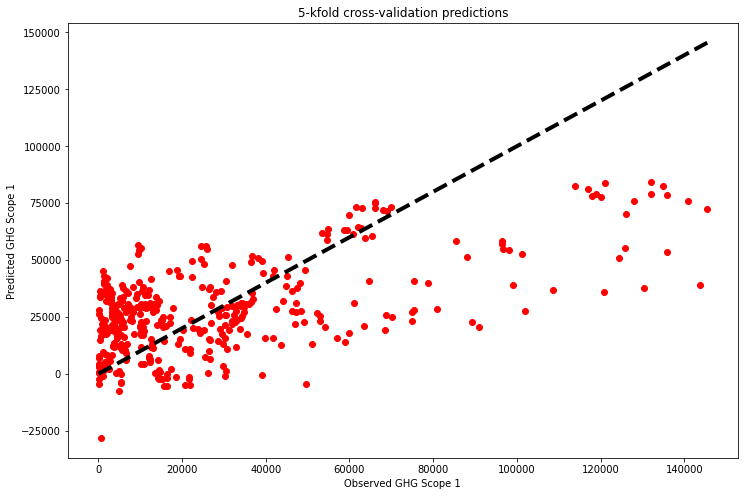

In [446]:
lr = LinearRegression()
kfold = KFold(n_splits=5, random_state = 42, shuffle=True)
predicted = cross_val_predict(lr, X, y, cv=kfold)

df_kfold = pd.DataFrame({'Observed':y.flatten(), 'Predicted': predicted.flatten()})
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(y, predicted, c='red')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Observed GHG Scope 1')
ax.set_ylabel('Predicted GHG Scope 1')
ax.set_title('5-kfold cross-validation predictions');

We see the data points are closer when considering the logarithmic value but the model continues to behave properly once the GHG Scope 1 starts increasing. 

In [447]:
df_model_eval.loc[len(df_model_eval.index)] = [8 , 'Linear (ln(Sales) + ln(Asset))', '5 K-fold',676789732.54,26015.18, 0.36] 
df_model_eval

,Model_Number,Model_Name,Approach,MSE,RMSE,R-Squared
0,1,Linear (Sales + Asset),Hold-out,596373921.627,24420.768,0.548
1,2,Linear (Sales + Asset),5 K-fold,572243005.350,23921.601,0.460
2,3,Ridge (Sales + Asset),Hold-out,593708829.454,24366.141,0.550
3,4,Ridge (Sales + Asset),5 K-fold,574765481.160,23974.267,0.460
4,5,Lasso (Sales + Assets),Hold-out,594565957.900,24383.723,0.549
5,6,Lasso (Sales + Assets),5 K-fold,572164056.060,23919.950,0.460
6,7,Linear (ln(Sales) + ln(Asset)),Hold-out,796139917.348,28215.951,0.396
7,8,Linear (ln(Sales) + ln(Asset)),5 K-fold,676789732.540,26015.180,0.360


### Ridge Regression 

#### Validation Set Approach - Hold out approach

Similar as model 1, we will continue applying different ML techniques to yield the lower MSE. First, we will go with Ridge Regression and apply the Hold Out approach which means we will use 80% for training and 20% for testing. 


We started with 100 alphas and instead of arbitrarily choosing alpha, we will use cross-validation to choose the tuning parameter alpha. 

In [448]:
n_alphas = 100
alphas = np.logspace(-10, -2, n_alphas)

X = df1.iloc[:,1:3].values
y = df1.iloc[:,0].values

# Split data into training and test sets
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv.fit(X_train, y_train)

ridge_1 = Ridge(alpha = ridgecv.alpha_, normalize = True)
ridge_1.fit(X_train, y_train)
y_train_pred = ridge_1.predict(X_train)
yhat_ridge = ridge_1.predict(X_test)

# Evaluate the model
print('Coefficients:', ridge_1.coef_)
print('Mean squared error: %.2f' % metrics.mean_squared_error(y_test, yhat_ridge))
print(f'Root Mean Squared Error: {np.sqrt(metrics.mean_squared_error(y_test, yhat_ridge))}')
print('Coefficient of determination: %.2f'% metrics.r2_score(y_test, yhat_ridge))

Coefficients: [ 1313.42965124 22112.24490986]
Mean squared error: 673204545.60
Root Mean Squared Error: 25946.185569382662
Coefficient of determination: 0.49


In [449]:
print('MSE train: %.3f, test: %.3f' % (metrics.mean_squared_error(y_train, y_train_pred),
                metrics.mean_squared_error(y_test, yhat_ridge)))

MSE train: 667261823.359, test: 673204545.601


In here, we continue to overfit but the difference is much lower than using plain Linear regression. Let's see what happens when we use k-fold validation to train and predict. 

#### K-fold validation

We applied cross validation to get the best alpha. However, now we are going to do k-fold cross validation to apply to train and test the data in different folds. 

We continued using the Ridge Regression with the best alpha but now using the K-fold cross validation to fit and predict. 

In [450]:
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv.fit(X,y)
ridge_2 = Ridge(alpha = ridgecv.alpha_, normalize = True)
kfold_cross_validation(5,X,y,ridge_2)

Mean squared error: 676843560.22
Root Mean Squared Error: 26016.217254164356
Coefficient of determination: 0.36


In [451]:
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv.fit(X,y)
ridge_2 = Ridge(alpha = ridgecv.alpha_, normalize = True)
kfold_cross_validation(10,X,y,ridge_2)

Mean squared error: 678366714.67
Root Mean Squared Error: 26045.473976657056
Coefficient of determination: 0.36


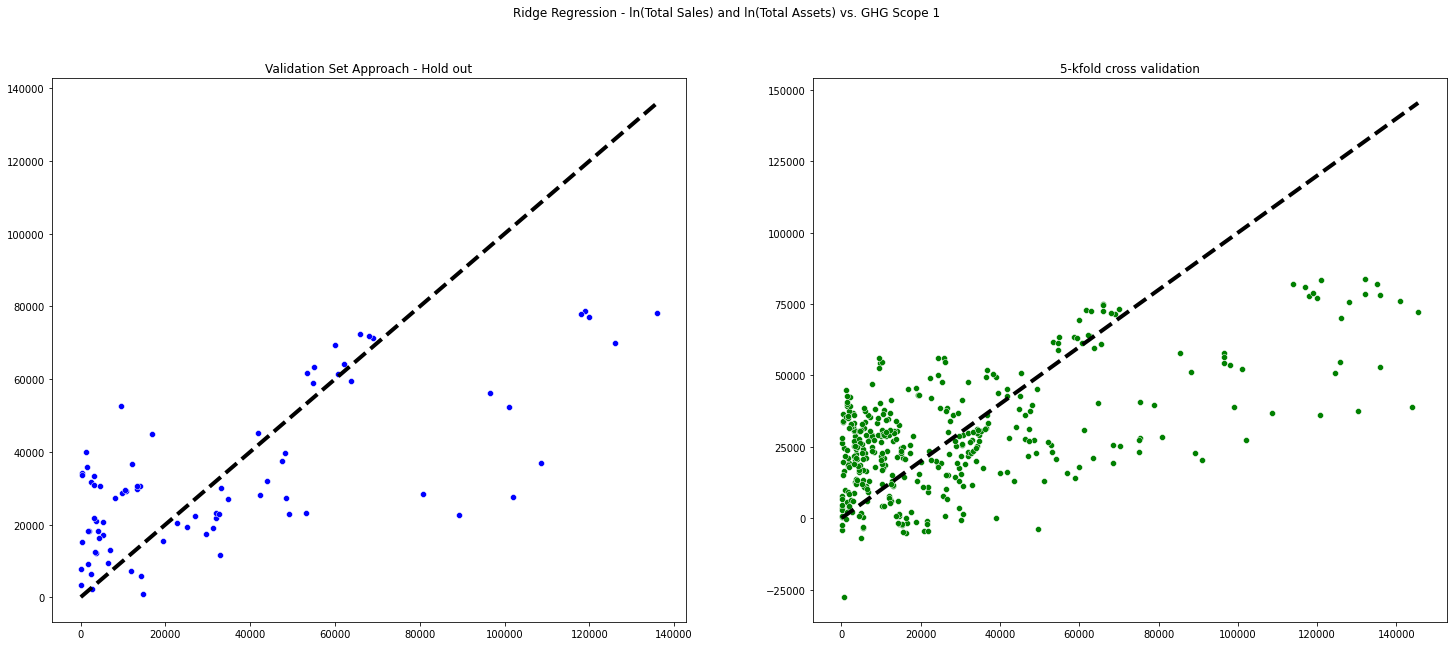

In [452]:
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv.fit(X,y)
ridge_3 = Ridge(alpha = ridgecv.alpha_, normalize = True)
kfold = KFold(n_splits=5, random_state = 42, shuffle=True)
predicted = cross_val_predict(ridge_3, X, y, cv=kfold)

fig, axs = plt.subplots(1,2, figsize=(25,10));
fig.suptitle('Ridge Regression - ln(Total Sales) and ln(Total Assets) vs. GHG Scope 1');
sns.scatterplot(x=y_test, y = yhat_ridge, ax=axs[0], color='b');
axs[0].set_title('Validation Set Approach - Hold out');
axs[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4);
sns.scatterplot(x=y, y = predicted, ax=axs[1], color='g');
axs[1].set_title('5-kfold cross validation');
axs[1].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4);

In [453]:
df_model_eval.loc[len(df_model_eval.index)] = [9 , 'Ridge (ln(Sales) + ln(Asset))', 'Hold-out',metrics.mean_squared_error(y_test,yhat_ridge), np.sqrt(metrics.mean_squared_error(y_test,yhat_ridge)), metrics.r2_score(y_test, yhat_ridge)] 
df_model_eval.loc[len(df_model_eval.index)] = [10 , 'Ridge (ln(Sales) + ln(Asset))', '5 K-fold',676843560.22, 26016.21, 0.36] 
df_model_eval

,Model_Number,Model_Name,Approach,MSE,RMSE,R-Squared
0,1,Linear (Sales + Asset),Hold-out,596373921.627,24420.768,0.548
1,2,Linear (Sales + Asset),5 K-fold,572243005.350,23921.601,0.460
2,3,Ridge (Sales + Asset),Hold-out,593708829.454,24366.141,0.550
3,4,Ridge (Sales + Asset),5 K-fold,574765481.160,23974.267,0.460
4,5,Lasso (Sales + Assets),Hold-out,594565957.900,24383.723,0.549
5,6,Lasso (Sales + Assets),5 K-fold,572164056.060,23919.950,0.460
6,7,Linear (ln(Sales) + ln(Asset)),Hold-out,796139917.348,28215.951,0.396
7,8,Linear (ln(Sales) + ln(Asset)),5 K-fold,676789732.540,26015.180,0.360
8,9,Ridge (ln(Sales) + ln(Asset)),Hold-out,673204545.601,25946.186,0.490
9,10,Ridge (ln(Sales) + ln(Asset)),5 K-fold,676843560.220,26016.210,0.360


### Lasso Regression

For Ridge regression, we pay a coefficient shrink penalty everytime we want minimize (shrink) the estimates coefficient to zero to lower the variance and get a lower MSE. Lasso Regression is very similar but it consider the absolute value which means it could get coefficients(predictos) towards zeros and simply not consider them in the regression.

We will apply this technique to see if we can yield a lower MSE than the one obtained using Ridge Regression (Hold out approach)


#### Validation Set Approach

As done previously, we subsert 80% to train and 20% to test. We first plot the weights and alphas to get a better idea 

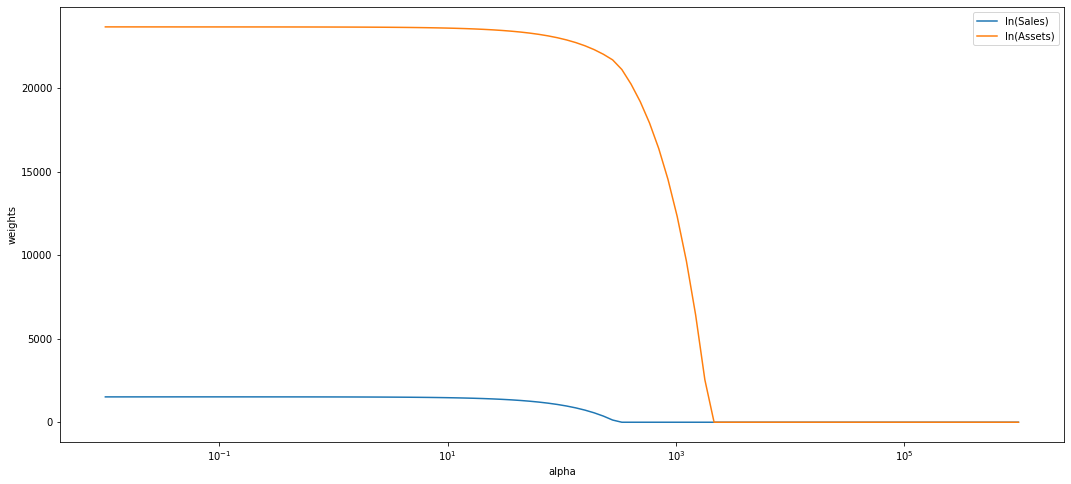

In [454]:
lasso = Lasso(max_iter = 10000, normalize = True)
coefs = []
errors = []
alphas = 10**np.linspace(6,-2,100)*0.5

X = df1.iloc[:,1:3].values
y = df1.iloc[:,0].values

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X, y)
    coefs.append(lasso.coef_)
    errors.append(metrics.mean_squared_error(lasso.predict(X), y))

plt.figure(figsize=(18, 8))
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.legend(['ln(Sales)', 'ln(Assets)'])
plt.xlabel('alpha')
plt.ylabel('weights');

The Assets feature is the one taking more time to shrink to zero which could tell us that is the predictor with more importance as it takes a higher lambda to decrease it to zero. The faster a coefficient is shrinking the less important it is in prediction

In [455]:
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
l_num = 100
pred_num = X.shape[1]

# prepare data for enumerate
coeff_a = np.zeros((l_num, pred_num))
train_r_squared = np.zeros(l_num)
test_r_squared = np.zeros(l_num)
train_mse = np.zeros(l_num)
test_mse = np.zeros(l_num)

for ind, i in enumerate(alphas):    
    reg = Lasso(alpha = i)
    reg.fit(X_train, y_train)

    coeff_a[ind,:] = reg.coef_
    train_r_squared[ind] = reg.score(X_train, y_train)
    test_r_squared[ind] = reg.score(X_test, y_test)
    train_mse[ind] = metrics.mean_squared_error(reg.predict(X_train), y_train)
    test_mse[ind] = metrics.mean_squared_error(reg.predict(X_test), y_test)

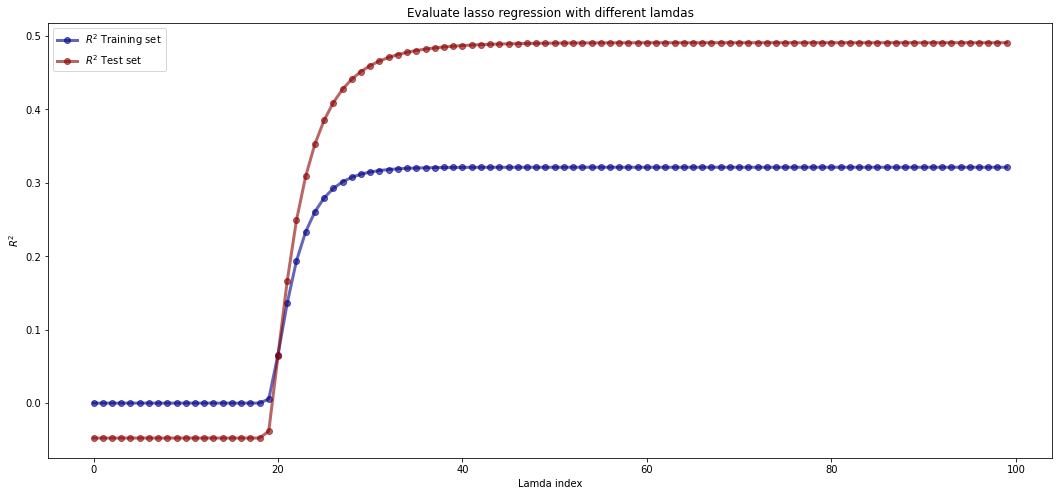

In [456]:
plt.figure(figsize=(18, 8))
plt.plot(train_r_squared, 'bo-', label=r'$R^2$ Training set', color="darkblue", alpha=0.6, linewidth=3)
plt.plot(test_r_squared, 'bo-', label=r'$R^2$ Test set', color="darkred", alpha=0.6, linewidth=3)
plt.xlabel('Lamda index'); plt.ylabel(r'$R^2$')
plt.title('Evaluate lasso regression with different lamdas');
plt.legend(loc='best');

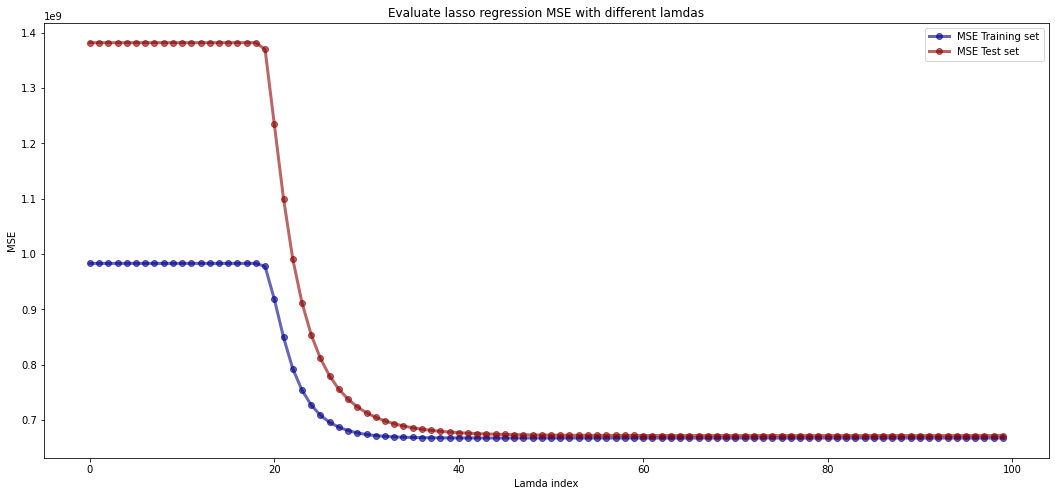

In [457]:
plt.figure(figsize=(18, 8))
plt.plot(train_mse, 'bo-', label=r'MSE Training set', color="darkblue", alpha=0.6, linewidth=3)
plt.plot(test_mse, 'bo-', label=r'MSE Test set', color="darkred", alpha=0.6, linewidth=3)
plt.xlabel('Lamda index'); plt.ylabel(r'MSE')
plt.ticklabel_format(useOffset= True)
plt.title('Evaluate lasso regression MSE with different lamdas');
plt.legend(loc='best');

In [458]:
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassocv.fit(X_train, y_train)

print(f'The optimal alpha is {lassocv.alpha_}')

The optimal alpha is 21.446791720769998


In [459]:
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
yhat_lasso = lasso.predict(X_test)

# Evaluate the model
print('Mean squared error: %.2f' % metrics.mean_squared_error(y_test, yhat_lasso))
print(f'Root Mean Squared Error: {np.sqrt(metrics.mean_squared_error(y_test, yhat_lasso))}')
print('Coefficient of determination: %.2f'% metrics.r2_score(y_test, yhat_lasso ))

Mean squared error: 677448074.61
Root Mean Squared Error: 26027.832691281208
Coefficient of determination: 0.49


#### K-fold validation

In [460]:
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassocv.fit(X, y)
lasso = Lasso(max_iter = 10000, normalize = True)
lasso.set_params(alpha=lassocv.alpha_)
kfold_cross_validation(5, X, y, lasso)

Mean squared error: 677754878.00
Root Mean Squared Error: 26033.725780316883
Coefficient of determination: 0.36


In [461]:
lasso = Lasso(max_iter = 10000, normalize = True)
lasso.set_params(alpha=lassocv.alpha_)
kfold_cross_validation(10, X, y, lasso)

Mean squared error: 679140400.97
Root Mean Squared Error: 26060.322349642694
Coefficient of determination: 0.36


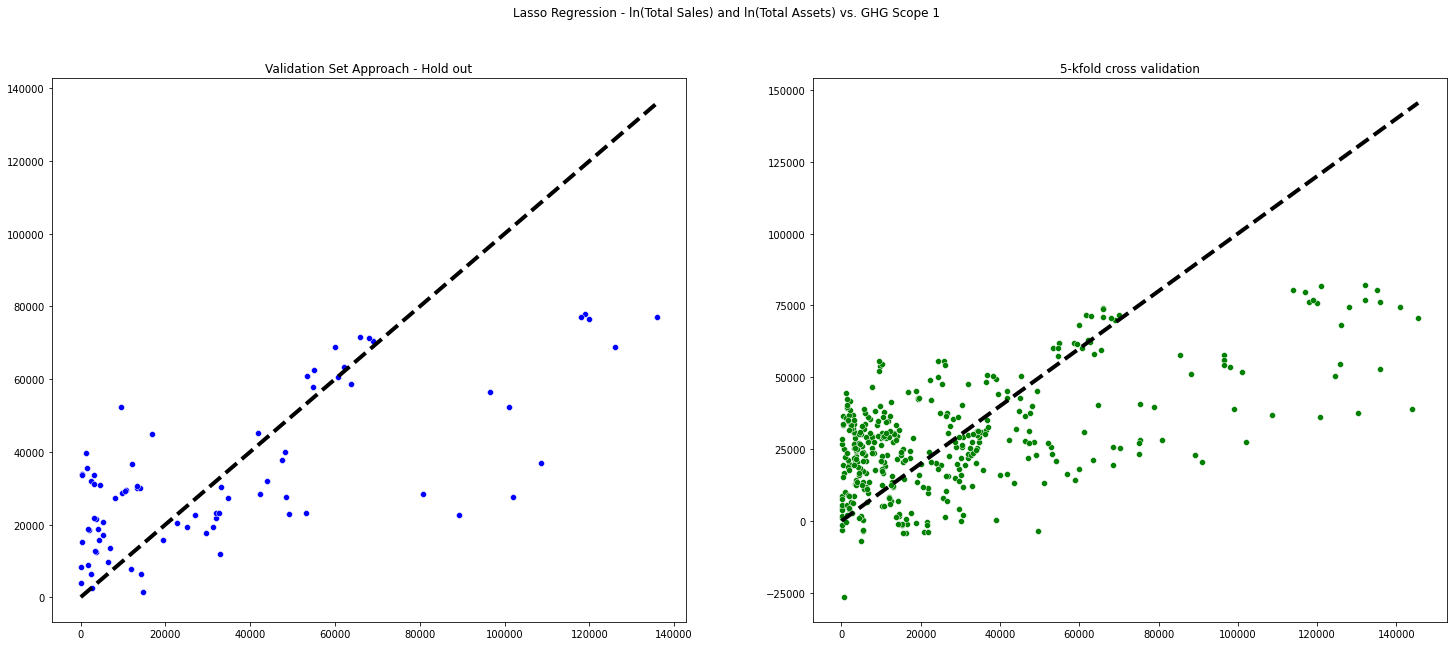

In [462]:
lasso = Lasso(max_iter = 10000, normalize = True)
lasso.set_params(alpha=lassocv.alpha_)
kfold = KFold(n_splits=5, random_state = 42, shuffle=True)
predicted = cross_val_predict(lasso, X, y, cv=kfold)

fig, axs = plt.subplots(1,2, figsize=(25,10));
fig.suptitle('Lasso Regression - ln(Total Sales) and ln(Total Assets) vs. GHG Scope 1');
sns.scatterplot(x=y_test, y = yhat_lasso, ax=axs[0], color='b');
axs[0].set_title('Validation Set Approach - Hold out');
axs[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4);
sns.scatterplot(x=y, y = predicted, ax=axs[1], color='g');
axs[1].set_title('5-kfold cross validation');
axs[1].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4);

In [463]:
df_model_eval.loc[len(df_model_eval.index)] = [11 , 'Lasso (ln(Sales) + ln(Asset))', 'Hold-out',metrics.mean_squared_error(y_test,yhat_lasso), np.sqrt(metrics.mean_squared_error(y_test,yhat_lasso)), metrics.r2_score(y_test, yhat_lasso)] 
df_model_eval.loc[len(df_model_eval.index)] = [12 , 'Lasso (ln(Sales) + ln(Asset))', '5 K-fold',677276647.87, 26024.53, 0.36] 
df_model_eval

,Model_Number,Model_Name,Approach,MSE,RMSE,R-Squared
0,1,Linear (Sales + Asset),Hold-out,596373921.627,24420.768,0.548
1,2,Linear (Sales + Asset),5 K-fold,572243005.350,23921.601,0.460
2,3,Ridge (Sales + Asset),Hold-out,593708829.454,24366.141,0.550
3,4,Ridge (Sales + Asset),5 K-fold,574765481.160,23974.267,0.460
4,5,Lasso (Sales + Assets),Hold-out,594565957.900,24383.723,0.549
5,6,Lasso (Sales + Assets),5 K-fold,572164056.060,23919.950,0.460
6,7,Linear (ln(Sales) + ln(Asset)),Hold-out,796139917.348,28215.951,0.396
7,8,Linear (ln(Sales) + ln(Asset)),5 K-fold,676789732.540,26015.180,0.360
8,9,Ridge (ln(Sales) + ln(Asset)),Hold-out,673204545.601,25946.186,0.490
9,10,Ridge (ln(Sales) + ln(Asset)),5 K-fold,676843560.220,26016.210,0.360


### Model 3 -  GHG for Energy vs Utilities

Now, we are going to consider a third model with the following predictors:

GHG = a + b1*Sales + b2*Assets + b3*Util + b5*TimeTrend + e


We are going to apply multiple ML techniques to help yield the lower MSE. 


#### Linear Regression - Validation set approach

First, we start with the Linear Regression and splitting the data into training and test. 

In [464]:
stock = stocks.copy()
stock.dropna(inplace=True, subset = ['Total_Assets','Total_Sales','GHG Scope 1'])

X = stock[['Total_Sales','Total_Assets','Utility','time_trend']]
y = stock['GHG Scope 1']
print(X.shape)
print(y.shape)

(398, 4)
(398,)


In [465]:
model = LinearRegression(fit_intercept=True) #Initialize model
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42) #Train and Test split
model.fit(Xtrain,ytrain) #Fit the model
y_train_pred = model.predict(Xtrain)
y_model = model.predict(Xtest) #Make predictions

In [466]:
print('MSE train: %.3f, test: %.3f' % (metrics.mean_squared_error(y_train, y_train_pred),
                metrics.mean_squared_error(y_test, y_model)))

MSE train: 454958285.737, test: 442891100.670


Now, we might be underfitting. We can see a small MSE train and MSE test. Let's see the model coefficients and other model accuracy metrics including R squared

In [467]:
#The coefficients
print('Coefficients: \n', model.coef_)
#Mean Squared Error
print('Mean squared error: %.2f' % metrics.mean_squared_error(ytest,y_model))
print(f'Root Mean Squared Error: {np.sqrt(metrics.mean_squared_error(ytest,y_model))}')
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % metrics.r2_score(ytest, y_model))

Coefficients: 
 [ 1.27217988e-01  2.83677679e-01  2.23421275e+04 -5.58358640e+02]
Mean squared error: 442891100.67
Root Mean Squared Error: 21044.978039190788
Coefficient of determination: 0.66


The first line presents the coefficients estimates. We can see that the time trend (cumulative value that the stock is in the dataset) is negative which means that each increase in years decreases the GHG Scope (direct emissions). For the other predictors, the relationship would be positive. On average, the total sales will increase by 0.127217988 times,  total assets by 0.283677679 and if is part of the utility industry then 22342.1275. We can notice the high coefficient estimate for *Utilities*. It seems, knowing the industry tells us a lot about the direct emissions. 

The predictive model 3 yields the lowest MSE and the hightest coefficient of determination (66%) compared to the other two predictive models. 

In [468]:
#Create data frame with observed and predicted
linear_reg = pd.DataFrame({'Observed':ytest,'Prediction':y_model})
linear_reg.head()

,Observed,Prediction
418,3577.300,-905.917
778,119000.000,125953.753
58,3410.000,-735.414
464,14296.500,19195.057
206,32000.000,26110.108


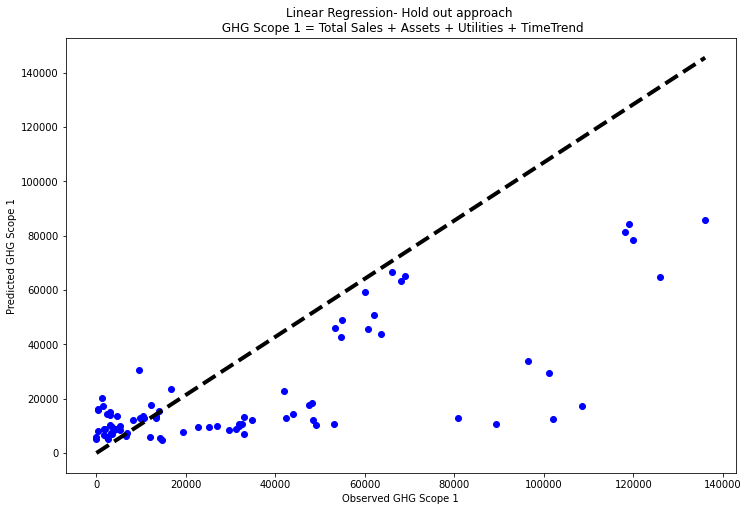

In [469]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(y_test, y_pred, c='blue')
ax.plot([y_test.min(), y_test.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Observed GHG Scope 1')
ax.set_ylabel('Predicted GHG Scope 1')
ax.set_title('Linear Regression- Hold out approach \n GHG Scope 1 = Total Sales + Assets + Utilities + TimeTrend');

The model accounts for 66% of the variance which is the hightest right now. However, we still can see points that are far away from the best fitted line meaning that we have big residuals. Moreover, we see a similar pattern from the other predictive models regarding that the model behaves badly once the GHG scope values start to increase. 

We will add this results to our models evaluation dataframe and continue applying other techniques. 

In [470]:
df_model_eval.loc[len(df_model_eval.index)] = [13, 'Linear (Sales + Asset + Utilities + Timetrend)', 'Hold-out', metrics.mean_squared_error(ytest,y_model), np.sqrt(metrics.mean_squared_error(ytest,y_model)), metrics.r2_score(ytest, y_model)]
df_model_eval.tail()

,Model_Number,Model_Name,Approach,MSE,RMSE,R-Squared
8,9,Ridge (ln(Sales) + ln(Asset)),Hold-out,673204545.601,25946.186,0.490
9,10,Ridge (ln(Sales) + ln(Asset)),5 K-fold,676843560.220,26016.210,0.360
10,11,Lasso (ln(Sales) + ln(Asset)),Hold-out,677448074.605,26027.833,0.486
11,12,Lasso (ln(Sales) + ln(Asset)),5 K-fold,677276647.870,26024.530,0.360
12,13,Linear (Sales + Asset + Utilities + Timetrend),Hold-out,442891100.670,21044.978,0.664


#### Linear regression with k-fold cross validation


Now, we will consider different k-folds to fit and predict. Let's see what happens!

In [471]:
X = X.values
y = y.values

In [472]:
model1 = LinearRegression()
kfold_cross_validation(5,X,y,model1)

Mean squared error: 458669164.20
Root Mean Squared Error: 21416.562847569556
Coefficient of determination: 0.57


In [473]:
kfold_cross_validation(10,X,y,model1)

Mean squared error: 462201730.55
Root Mean Squared Error: 21498.877425240873
Coefficient of determination: 0.56


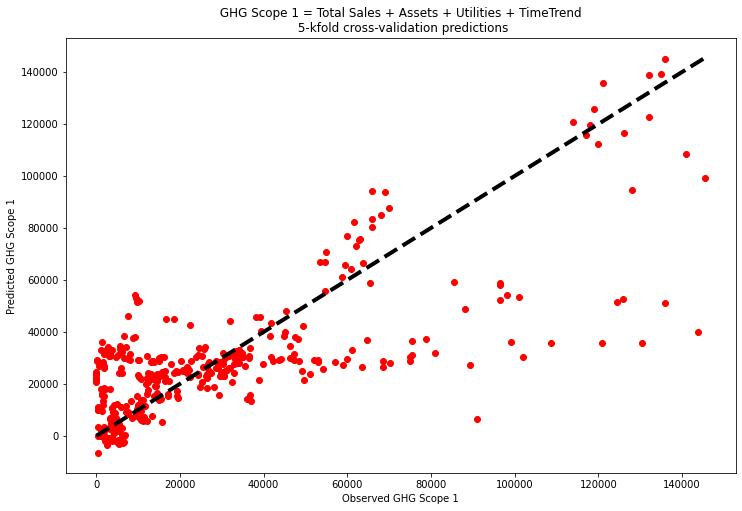

In [474]:
lr = LinearRegression()
kfold = KFold(n_splits=5, random_state = 42, shuffle=True)
predicted = cross_val_predict(lr, X, y, cv=kfold)

df_kfold = pd.DataFrame({'Observed':y.flatten(), 'Predicted': predicted.flatten()})
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(y, predicted, c='red')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Observed GHG Scope 1')
ax.set_ylabel('Predicted GHG Scope 1')
ax.set_title(' GHG Scope 1 = Total Sales + Assets + Utilities + TimeTrend \n 5-kfold cross-validation predictions');

With 5-Fold cross validation, we are using several folds for training and testing. Therefore, we have more observations to train the model. 

The plot presents small residuals (small difference between the observed and predicted GHG Scope) at the beginning but once the GHG Scope 1 starts increasing we can see the predictions are out of target. However, this model has a lower MSE but it only accounts for 57%. 

We will add this results to the models evaluation dataframe and continue applying other techniques. 

In [475]:
df_model_eval.loc[len(df_model_eval.index)] = [14, 'Linear (Sales + Asset + Utilities + Timetrend)', '5 K-fold' , 
                                               458669164.20,  21416.56 ,0.57 ] 
df_model_eval.tail()

,Model_Number,Model_Name,Approach,MSE,RMSE,R-Squared
9,10,Ridge (ln(Sales) + ln(Asset)),5 K-fold,676843560.220,26016.210,0.360
10,11,Lasso (ln(Sales) + ln(Asset)),Hold-out,677448074.605,26027.833,0.486
11,12,Lasso (ln(Sales) + ln(Asset)),5 K-fold,677276647.870,26024.530,0.360
12,13,Linear (Sales + Asset + Utilities + Timetrend),Hold-out,442891100.670,21044.978,0.664
13,14,Linear (Sales + Asset + Utilities + Timetrend),5 K-fold,458669164.200,21416.560,0.570


### Ridge Regression

Now, we are going to consider the Ridge regression to work with the variance-bias tradeoff. From the other models, we identified they were overfitting the data. Maybe, Ridge Regression could helps with that. 

As a reminder, by shrinking the coefficient estimates we can significantly reduce their variance. 

#### Validation set approach

First, we are going to consider 100 alphas and see how the coefficients behave as a function of the regularization. Let's remember, a higher alpha (lambda) means lower coefficients leading to less variance but increased bias. 



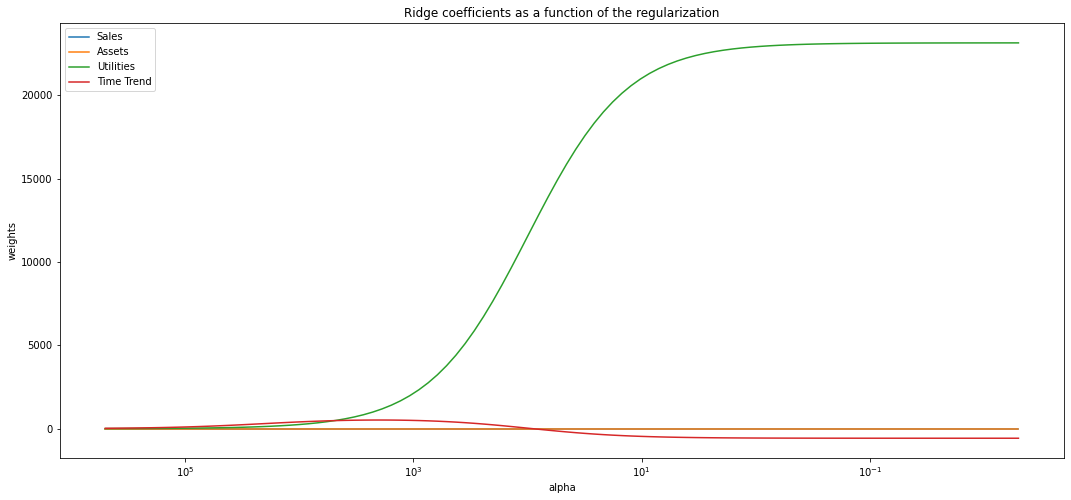

In [476]:
n_alphas = 100
alphas = 10**np.linspace(6,-2,100)*0.5

X = stock[['Total_Sales','Total_Assets','Utility','time_trend']].values
y = stock['GHG Scope 1'].values

coefs = []
for a in alphas:
    ridge = Ridge(alpha=a, fit_intercept=False, normalize=True)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)

plt.figure(figsize=(18, 8))
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.legend(['Sales', 'Assets','Utilities','Time Trend'])
plt.axis('tight');

We can see the Utilities line is the one that takes longer to shrink to zero which could mean is the feature with more importance in this regression. 

In [477]:
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
l_num = 100
pred_num = X.shape[1]

# prepare data for enumerate
coeff_a = np.zeros((l_num, pred_num))
train_r_squared = np.zeros(l_num)
test_r_squared = np.zeros(l_num)
train_mse = np.zeros(l_num)
test_mse = np.zeros(l_num)

for ind, i in enumerate(alphas):    
    reg = Ridge(alpha = i)
    reg.fit(X_train, y_train)

    coeff_a[ind,:] = reg.coef_
    train_r_squared[ind] = reg.score(X_train, y_train)
    test_r_squared[ind] = reg.score(X_test, y_test)
    train_mse[ind] = metrics.mean_squared_error(reg.predict(X_train), y_train)
    test_mse[ind] = metrics.mean_squared_error(reg.predict(X_test), y_test)

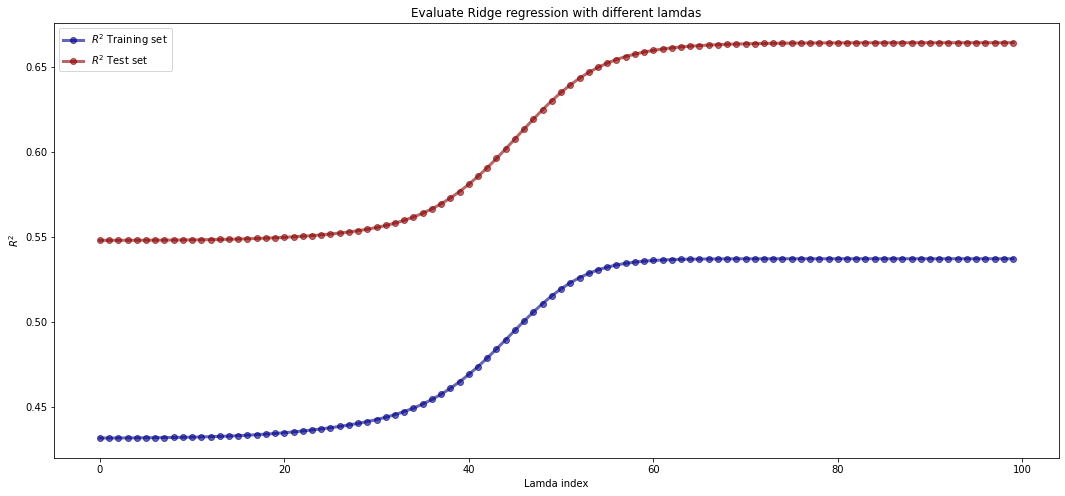

In [478]:
plt.figure(figsize=(18, 8))
plt.plot(train_r_squared, 'bo-', label=r'$R^2$ Training set', color="darkblue", alpha=0.6, linewidth=3)
plt.plot(test_r_squared, 'bo-', label=r'$R^2$ Test set', color="darkred", alpha=0.6, linewidth=3)
plt.xlabel('Lamda index'); plt.ylabel(r'$R^2$')
plt.title('Evaluate Ridge regression with different lamdas');
plt.legend(loc='best');

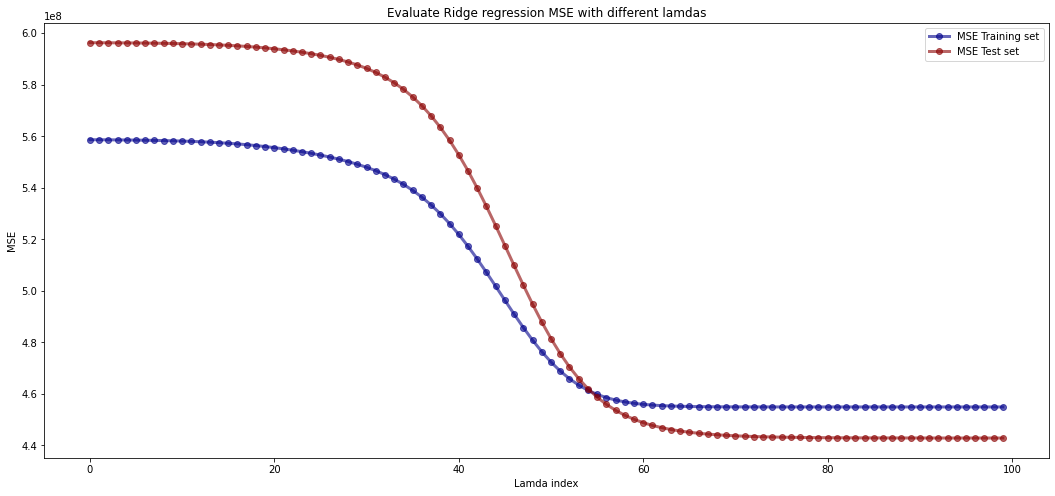

In [479]:
plt.figure(figsize=(18, 8))
plt.plot(train_mse, 'bo-', label=r'MSE Training set', color="darkblue", alpha=0.6, linewidth=3)
plt.plot(test_mse, 'bo-', label=r'MSE Test set', color="darkred", alpha=0.6, linewidth=3)
plt.xlabel('Lamda index'); plt.ylabel(r'MSE')
plt.ticklabel_format(useOffset= True)
plt.title('Evaluate Ridge regression MSE with different lamdas');
plt.legend(loc='best');

Instead of arbitrarily choosing alpha, we used cross-validation to choose the tuning parameter alpha. 

In [480]:
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv.fit(X_train, y_train)
print(f'The optimal alpha is {ridgecv.alpha_}')

The optimal alpha is 0.03214036558642153


In [481]:
ridge_1 = Ridge(alpha = ridgecv.alpha_, normalize = True)
ridge_1.fit(X_train, y_train)
yhat_ridge = ridge_1.predict(X_test)

# Evaluate the model
print('Mean squared error: %.2f' % metrics.mean_squared_error(y_test, yhat_ridge))
print(f'Root Mean Squared Error: {np.sqrt(metrics.mean_squared_error(y_test, yhat_ridge))}')
print('Coefficient of determination: %.2f'% metrics.r2_score(y_test, yhat_ridge))

Mean squared error: 440868694.30
Root Mean Squared Error: 20996.873440961255
Coefficient of determination: 0.67


### Ridge Regression 

##### K-fold cross validation approach



In [482]:
ridge_1 = Ridge(alpha = ridgecv.alpha_, normalize = True)
kfold_cross_validation(10,X,y,ridge_1)

Mean squared error: 462102351.42
Root Mean Squared Error: 21496.566037753404
Coefficient of determination: 0.56


In [483]:
ridge_1 = Ridge(alpha = ridgecv.alpha_, normalize = True)
kfold_cross_validation(5,X,y,ridge_1)

Mean squared error: 458561639.41
Root Mean Squared Error: 21414.05238170476
Coefficient of determination: 0.57


In [484]:
ridge_1 = Ridge(alpha = ridgecv.alpha_, normalize = True)
kfold_cross_validation(2,X,y,ridge_1)

Mean squared error: 460947190.17
Root Mean Squared Error: 21469.680718916203
Coefficient of determination: 0.57


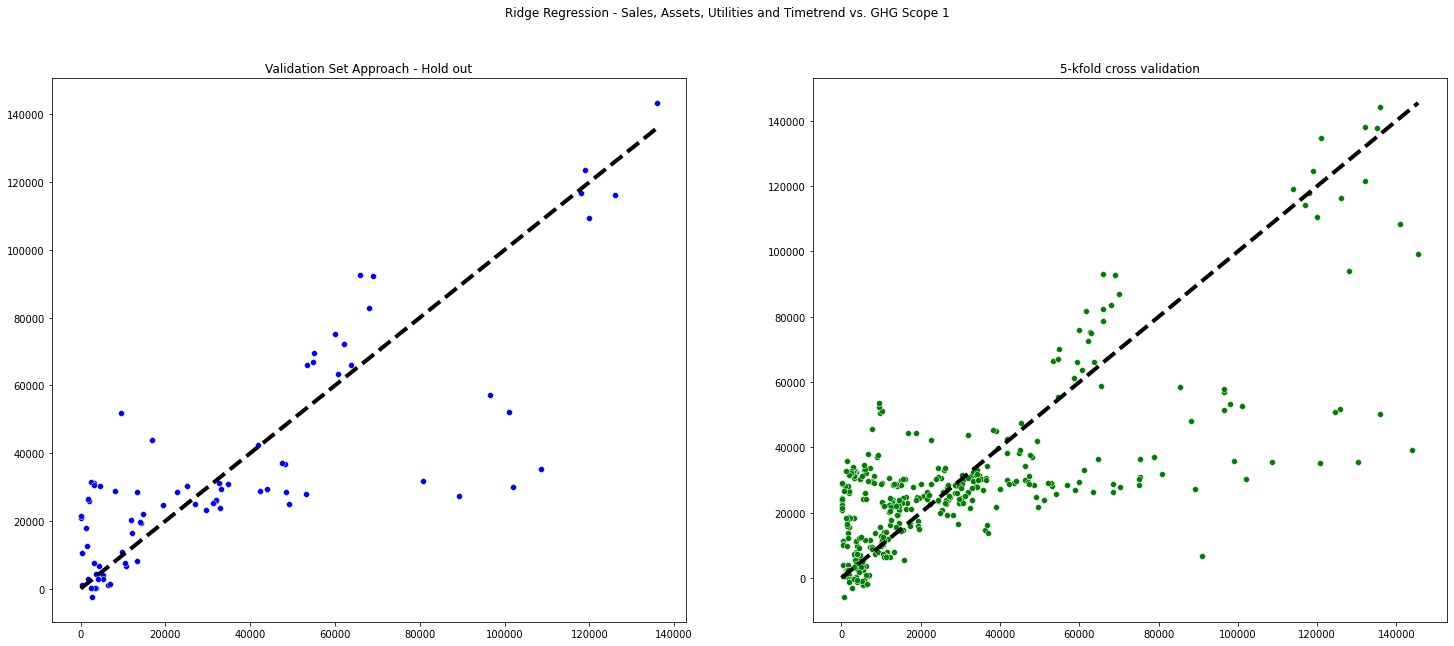

In [485]:
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv.fit(X,y)
ridge_3 = Ridge(alpha = ridgecv.alpha_, normalize = True)
kfold = KFold(n_splits=5, random_state = 42, shuffle=True)
predicted = cross_val_predict(ridge_3, X, y, cv=kfold)

fig, axs = plt.subplots(1,2, figsize=(25,10));
fig.suptitle('Ridge Regression - Sales, Assets, Utilities and Timetrend vs. GHG Scope 1');
sns.scatterplot(x=y_test, y = yhat_ridge, ax=axs[0], color='b');
axs[0].set_title('Validation Set Approach - Hold out');
axs[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4);
sns.scatterplot(x=y, y = predicted, ax=axs[1], color='g');
axs[1].set_title('5-kfold cross validation');
axs[1].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4);

In [486]:
df_model_eval.loc[len(df_model_eval.index)] = [15, 'Ridge (Sales + Asset + Utilities + Timetrend)', 'Hold-out', 
                                               metrics.mean_squared_error(y_test, yhat_ridge), np.sqrt(metrics.mean_squared_error(y_test, yhat_ridge)), metrics.r2_score(y_test, yhat_ridge)] 
df_model_eval.loc[len(df_model_eval.index)] = [16, 'Ridge (Sales + Asset + Utilities + Timetrend)', '5 K-fold', 458561639.41, 21414.05 ,0.57 ]
df_model_eval.tail()

,Model_Number,Model_Name,Approach,MSE,RMSE,R-Squared
11,12,Lasso (ln(Sales) + ln(Asset)),5 K-fold,677276647.870,26024.530,0.360
12,13,Linear (Sales + Asset + Utilities + Timetrend),Hold-out,442891100.670,21044.978,0.664
13,14,Linear (Sales + Asset + Utilities + Timetrend),5 K-fold,458669164.200,21416.560,0.570
14,15,Ridge (Sales + Asset + Utilities + Timetrend),Hold-out,440868694.296,20996.873,0.666
15,16,Ridge (Sales + Asset + Utilities + Timetrend),5 K-fold,458561639.410,21414.050,0.570


#### Lasso Regression

Lasso Regression could get coefficients(predictos) towards zeros and simply not consider them in the regression.

We will apply this technique to see if we can yield a lower MSE than the one obtained using Ridge Regression (Hold out approach)


First, we will plot the weights and alphas to see get a better idea of the feature importance. 

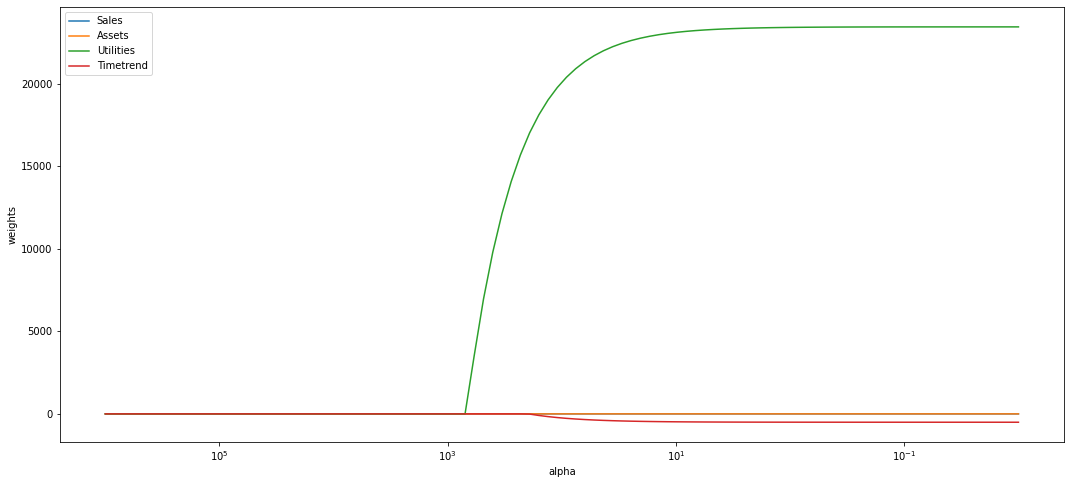

In [487]:
lasso = Lasso(max_iter = 10000, normalize = True)
coefs = []
errors = []
alphas = 10**np.linspace(6,-2,100)*0.5

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X, y)
    coefs.append(lasso.coef_)
    errors.append(metrics.mean_squared_error(lasso.predict(X), y))

plt.figure(figsize=(18, 8))
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.legend(['Sales', 'Assets','Utilities','Timetrend'])
plt.xlabel('alpha')
plt.ylabel('weights');

We can see a similar pattern from Ridge regresion, the Utilities feature seem to have more weights and the others one are easier to yiel toward zero. 

#### Validation Set Approach

As done previously, we subset 80% to train and 20% to test. We first plot the weights and alphas to get a better idea 

In [488]:
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
l_num = 100
pred_num = X.shape[1]

# prepare data for enumerate
coeff_a = np.zeros((l_num, pred_num))
train_r_squared = np.zeros(l_num)
test_r_squared = np.zeros(l_num)
train_mse = np.zeros(l_num)
test_mse = np.zeros(l_num)

for ind, i in enumerate(alphas):    
    reg = Lasso(alpha = i)
    reg.fit(X_train, y_train)

    coeff_a[ind,:] = reg.coef_
    train_r_squared[ind] = reg.score(X_train, y_train)
    test_r_squared[ind] = reg.score(X_test, y_test)
    train_mse[ind] = metrics.mean_squared_error(reg.predict(X_train), y_train)
    test_mse[ind] = metrics.mean_squared_error(reg.predict(X_test), y_test)

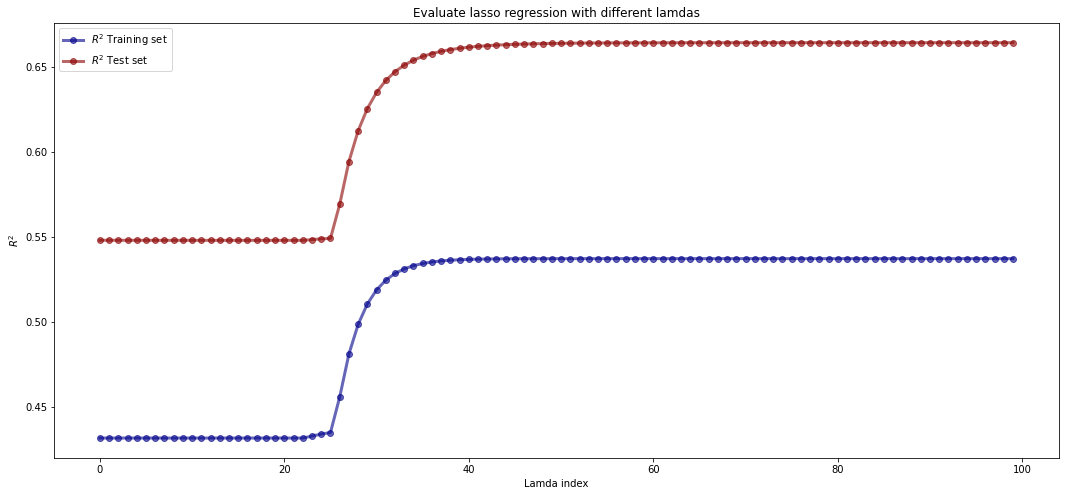

In [489]:
plt.figure(figsize=(18, 8))
plt.plot(train_r_squared, 'bo-', label=r'$R^2$ Training set', color="darkblue", alpha=0.6, linewidth=3)
plt.plot(test_r_squared, 'bo-', label=r'$R^2$ Test set', color="darkred", alpha=0.6, linewidth=3)
plt.xlabel('Lamda index'); plt.ylabel(r'$R^2$')
plt.title('Evaluate lasso regression with different lamdas');
plt.legend(loc='best');

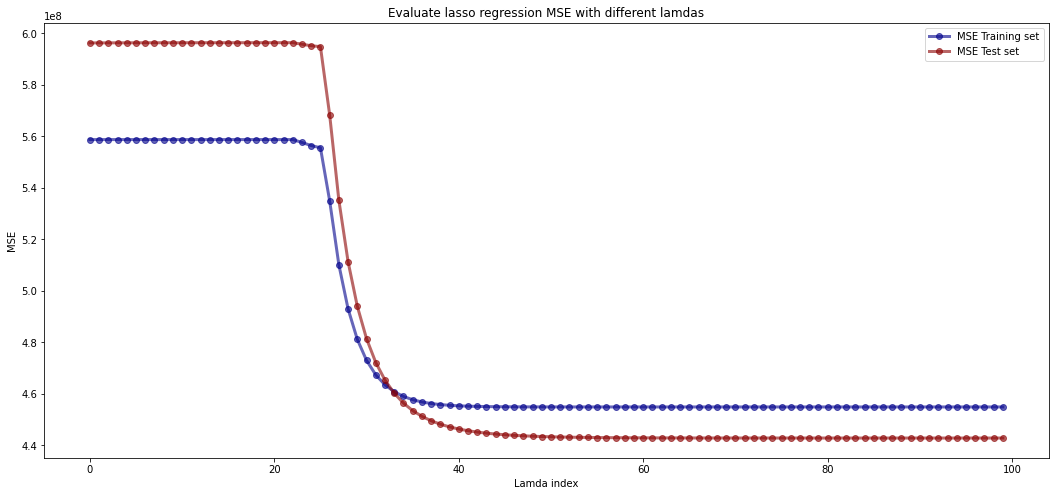

In [490]:
plt.figure(figsize=(18, 8))
plt.plot(train_mse, 'bo-', label=r'MSE Training set', color="darkblue", alpha=0.6, linewidth=3)
plt.plot(test_mse, 'bo-', label=r'MSE Test set', color="darkred", alpha=0.6, linewidth=3)
plt.xlabel('Lamda index'); plt.ylabel(r'MSE')
plt.title('Evaluate lasso regression MSE with different lamdas');
plt.legend(loc='best');

In [491]:
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassocv.fit(X_train, y_train)

print(f'The optimal alpha is {lassocv.alpha_}')

The optimal alpha is 1.1532714502900596


In [492]:
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
yhat_lasso = lasso.predict(X_test)

# Evaluate the model
print(f'Coefficients \n {lasso.coef_}')
print('Mean squared error: %.2f' % metrics.mean_squared_error(y_test, yhat_lasso))
print(f'Root Mean Squared Error: {np.sqrt(metrics.mean_squared_error(y_test, yhat_lasso))}')
print('Coefficient of determination: %.2f'% metrics.r2_score(y_test, yhat_lasso ))

Coefficients 
 [ 1.26963660e-01  2.83413531e-01  2.22758017e+04 -5.52637279e+02]
Mean squared error: 442776564.91
Root Mean Squared Error: 21042.25664955323
Coefficient of determination: 0.66


#### Lasso Regression

##### Cross validation approach

Now, we are going to consider different folds to fit and predict while using the best alpha. 

In [493]:
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassocv.fit(X, y)
lasso = Lasso(max_iter = 10000, normalize = True)
lasso.set_params(alpha=lassocv.alpha_)
kfold_cross_validation(5, X, y, lasso)

Mean squared error: 458655456.26
Root Mean Squared Error: 21416.24281378086
Coefficient of determination: 0.57


In [494]:
lasso = Lasso(max_iter = 10000, normalize = True)
lasso.set_params(alpha=lassocv.alpha_)
kfold_cross_validation(10, X, y, lasso)

Mean squared error: 462209134.98
Root Mean Squared Error: 21499.049629589823
Coefficient of determination: 0.56


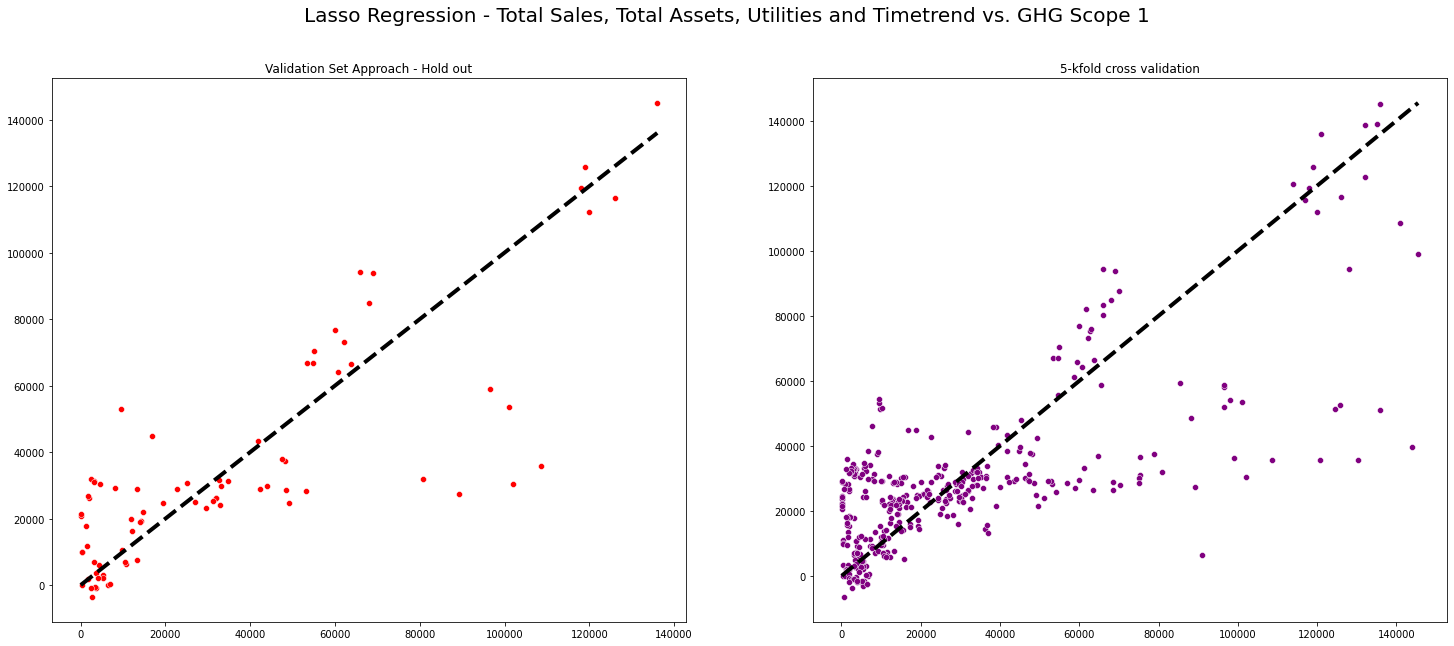

In [495]:
lasso = Lasso(max_iter = 10000, normalize = True)
lasso.set_params(alpha=lassocv.alpha_)
kfold = KFold(n_splits=5, random_state = 42, shuffle=True)
predicted = cross_val_predict(lasso, X, y, cv=kfold)

fig, axs = plt.subplots(1,2, figsize=(25,10));
fig.suptitle('Lasso Regression - Total Sales, Total Assets, Utilities and Timetrend vs. GHG Scope 1', fontsize=20);
sns.scatterplot(x=y_test, y = yhat_lasso, ax=axs[0], color='red');
axs[0].set_title('Validation Set Approach - Hold out');
axs[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4);
sns.scatterplot(x=y, y = predicted, ax=axs[1], color='purple');
axs[1].set_title('5-kfold cross validation');
axs[1].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4);

In [496]:
df_model_eval.loc[len(df_model_eval.index)] = [17, 'Lasso (Sales + Asset + Utilities + Timetrend)','Hold-out', metrics.mean_squared_error(y_test, yhat_lasso), 
                                               np.sqrt(metrics.mean_squared_error(y_test, yhat_lasso)),metrics.r2_score(y_test, yhat_lasso ) ] 
df_model_eval.loc[len(df_model_eval.index)] = [18, 'Lasso (Sales + Asset + Utilities + Timetrend)','5 K-fold', 458655027.23, 21416.23, 0.57 ] 
df_model_eval.tail()

,Model_Number,Model_Name,Approach,MSE,RMSE,R-Squared
13,14,Linear (Sales + Asset + Utilities + Timetrend),5 K-fold,458669164.200,21416.560,0.570
14,15,Ridge (Sales + Asset + Utilities + Timetrend),Hold-out,440868694.296,20996.873,0.666
15,16,Ridge (Sales + Asset + Utilities + Timetrend),5 K-fold,458561639.410,21414.050,0.570
16,17,Lasso (Sales + Asset + Utilities + Timetrend),Hold-out,442776564.906,21042.257,0.664
17,18,Lasso (Sales + Asset + Utilities + Timetrend),5 K-fold,458655027.230,21416.230,0.570


### Model 4 -  GHG for Energy vs Utilities using natural logarithms

The four and last predictive model is similar to the third one but considering the logarithm value for each predictor. We hope that in this way we can have a more linear distribution and help our model performance. 

We are going to work with the following formula:

ln(GHG) = a + b1*ln(Sales) + b2*ln(Assets) + b3*(Util) + b5*(TimeTrend) + e


#### Linear Regression

We are going to start with the Linear regression and then keep applying other regressions. Similar as we did for the other models. 

#### Validation set approach - Hold out 

We subset the data in training (80%) and test (20%). 

In [497]:
X=stock[['Logarithm_Total_Sales','Logarithm_Total_Assets','Utility','time_trend']].copy().values
y=stock['GHG Scope 1'].copy().values

In [498]:
model = LinearRegression(fit_intercept=True) #Initialize model
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42) #Train and Test split
model.fit(Xtrain,ytrain) #Fit the model
y_train_pred = model.predict(Xtrain)
y_model = model.predict(Xtest) #Make predictions

In [499]:
print('MSE train: %.3f, test: %.3f' % (metrics.mean_squared_error(ytrain, y_train_pred),
                metrics.mean_squared_error(ytest, y_model)))

MSE train: 561248063.480, test: 554112883.075


We see similar results as model 3. The MSE test is lower than MSE train. Let's see other model metrics. 

In [500]:
#The coefficients
print('Coefficients: \n', model.coef_)
#Mean Squared Error
print('Mean squared error: %.2f' % metrics.mean_squared_error(ytest,y_model))
print(f'Root Mean Squared Error: {np.sqrt(metrics.mean_squared_error(ytest,y_model))}')
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % metrics.r2_score(ytest, y_model))

Coefficients: 
 [11891.49071527 14604.97354257 26217.90450215  -632.58702587]
Mean squared error: 554112883.07
Root Mean Squared Error: 23539.602440878705
Coefficient of determination: 0.58


In [501]:
#Create data frame with observed and predicted
linear_reg4 = pd.DataFrame({'Observed':ytest,'Prediction':y_model})
linear_reg4.head()

,Observed,Prediction
0,3577.300,-10082.003
1,119000.000,75597.536
2,3410.000,-8221.854
3,14296.500,5318.176
4,32000.000,29450.978


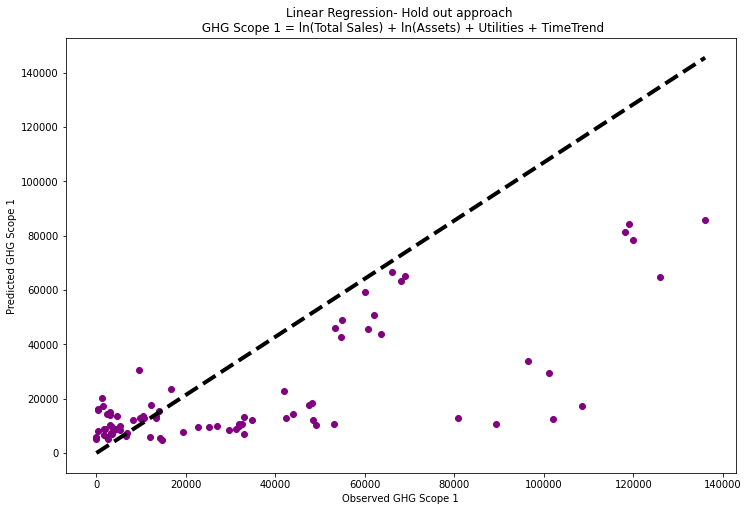

In [502]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(y_test, y_pred, c='purple')
ax.plot([y_test.min(), y_test.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Observed GHG Scope 1')
ax.set_ylabel('Predicted GHG Scope 1')
ax.set_title('Linear Regression- Hold out approach \n GHG Scope 1 = ln(Total Sales) + ln(Assets) + Utilities + TimeTrend');

The plot presents that the model predict accurately the first observations but once the GHG Scope starts increasing, it behaves badly. Moreover, the majority of the off-target fitted values are below the fitted line. This model accounts for 66% of the dataset variance. 

We will try k-fold validation to see if we can come up with a better performance. 

### K-fold cross validation

In [503]:
model1 = LinearRegression()
kfold_cross_validation(10,X,y,model1)

Mean squared error: 573588826.16
Root Mean Squared Error: 23949.714531835565
Coefficient of determination: 0.46


In [504]:
kfold_cross_validation(5,X,y,model1)

Mean squared error: 569033682.28
Root Mean Squared Error: 23854.42689056714
Coefficient of determination: 0.46


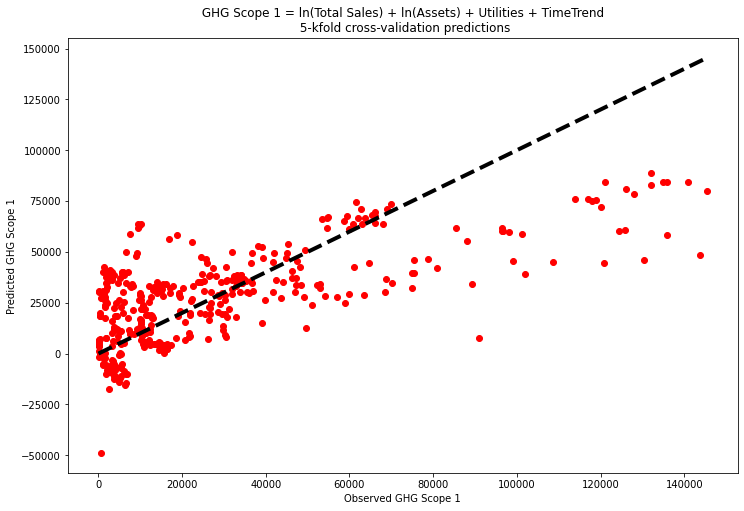

In [505]:
lr = LinearRegression()
kfold = KFold(n_splits=5, random_state = 42, shuffle=True)
predicted = cross_val_predict(lr, X, y, cv=kfold)

df_kfold = pd.DataFrame({'Observed':y.flatten(), 'Predicted': predicted.flatten()})
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(y, predicted, c='red')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Observed GHG Scope 1')
ax.set_ylabel('Predicted GHG Scope 1')
ax.set_title(' GHG Scope 1 = ln(Total Sales) + ln(Assets) + Utilities + TimeTrend \n 5-kfold cross-validation predictions');

In [506]:
df_model_eval.loc[len(df_model_eval.index)] = [19, 'Linear (ln(Sales) + ln(Asset) + Utilities + Timetrend)', 'Hold-out' , metrics.mean_squared_error(ytest,y_model),
                                               np.sqrt(metrics.mean_squared_error(ytest,y_model)),metrics.r2_score(ytest, y_model) ] 
df_model_eval.loc[len(df_model_eval.index)] = [20, 'Linear (ln(Sales) + ln(Asset) + Utilities + Timetrend)', '5 K-fold' ,458669164.20,
                                               21416.56,0.57 ] 
df_model_eval.tail()

,Model_Number,Model_Name,Approach,MSE,RMSE,R-Squared
15,16,Ridge (Sales + Asset + Utilities + Timetrend),5 K-fold,458561639.410,21414.050,0.570
16,17,Lasso (Sales + Asset + Utilities + Timetrend),Hold-out,442776564.906,21042.257,0.664
17,18,Lasso (Sales + Asset + Utilities + Timetrend),5 K-fold,458655027.230,21416.230,0.570
18,19,Linear (ln(Sales) + ln(Asset) + Utilities + Ti...,Hold-out,554112883.075,23539.602,0.580
19,20,Linear (ln(Sales) + ln(Asset) + Utilities + Ti...,5 K-fold,458669164.200,21416.560,0.570


### Ridge Regression

As done with the other models, we are going to apply Ridge Regression to try to yield a lower MSE than 442891100.0


First, we are going to plot the weights and alphas to see how each feature behaves. 

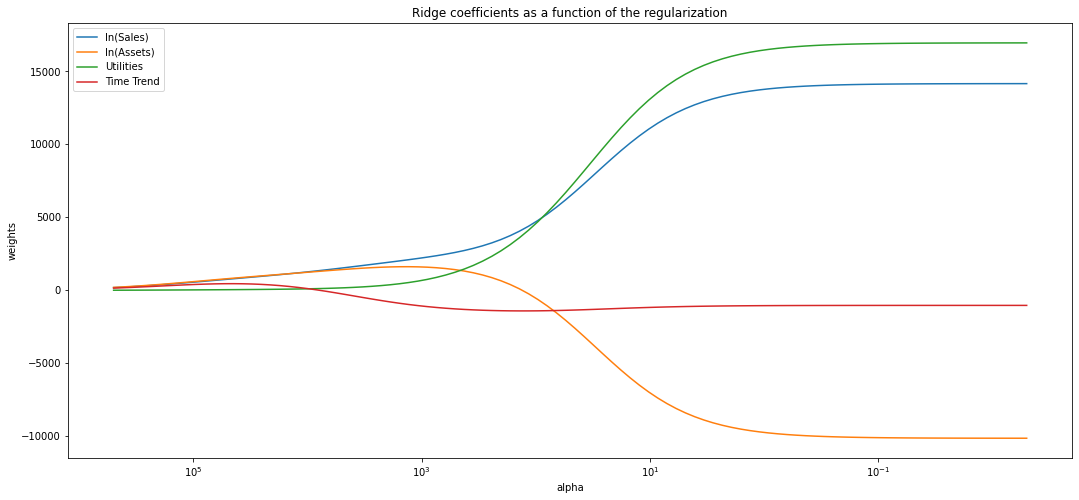

In [507]:
n_alphas = 100
alphas = 10**np.linspace(6,-2,100)*0.5

X=stock[['Logarithm_Total_Sales','Logarithm_Total_Assets','Utility','time_trend']].copy().values
y=stock['GHG Scope 1'].copy().values

coefs = []
for a in alphas:
    ridge = Ridge(alpha=a, fit_intercept=False, normalize=True)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)

plt.figure(figsize=(18, 8))
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.legend(['ln(Sales)', 'ln(Assets)','Utilities','Time Trend'])
plt.axis('tight');

This is the best weights vs. lambda so far. We can see how the four features get closer to zero as alpha increases. It seems the time trend is the least important predictor but the other three take high lambdas to get it to shrink. 

#### Validation set approach

We will know make fit and make predictions but first we will subset into training (80%) and test (20%). 

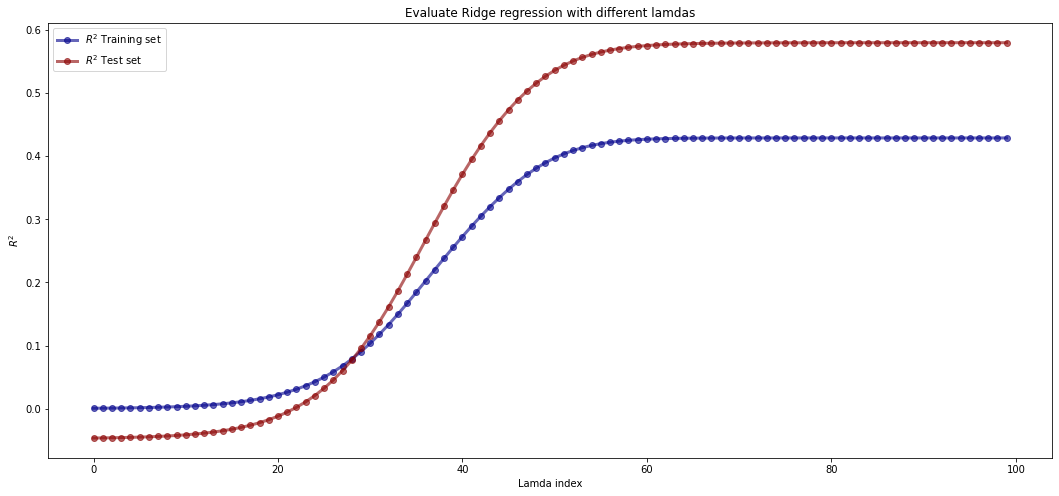

In [508]:
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
l_num = 100
pred_num = X.shape[1]

# prepare data for enumerate
coeff_a = np.zeros((l_num, pred_num))
train_r_squared = np.zeros(l_num)
test_r_squared = np.zeros(l_num)
train_mse = np.zeros(l_num)
test_mse = np.zeros(l_num)

for ind, i in enumerate(alphas):    
    reg = Ridge(alpha = i)
    reg.fit(X_train, y_train)

    coeff_a[ind,:] = reg.coef_
    train_r_squared[ind] = reg.score(X_train, y_train)
    test_r_squared[ind] = reg.score(X_test, y_test)
    train_mse[ind] = metrics.mean_squared_error(reg.predict(X_train), y_train)
    test_mse[ind] = metrics.mean_squared_error(reg.predict(X_test), y_test)
    
plt.figure(figsize=(18, 8))
plt.plot(train_r_squared, 'bo-', label=r'$R^2$ Training set', color="darkblue", alpha=0.6, linewidth=3)
plt.plot(test_r_squared, 'bo-', label=r'$R^2$ Test set', color="darkred", alpha=0.6, linewidth=3)
plt.xlabel('Lamda index'); plt.ylabel(r'$R^2$')
plt.title('Evaluate Ridge regression with different lamdas');
plt.legend(loc='best');

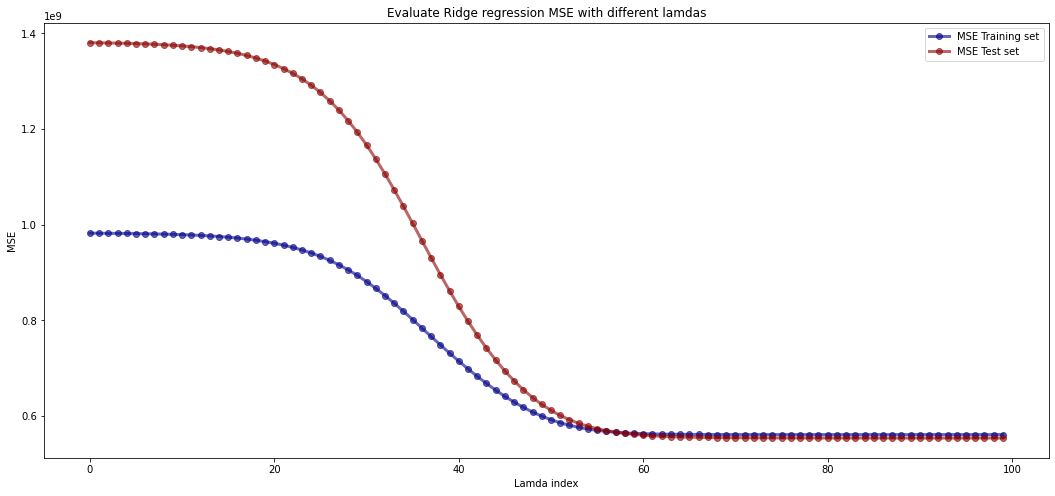

In [509]:
plt.figure(figsize=(18, 8))
plt.plot(train_mse, 'bo-', label=r'MSE Training set', color="darkblue", alpha=0.6, linewidth=3)
plt.plot(test_mse, 'bo-', label=r'MSE Test set', color="darkred", alpha=0.6, linewidth=3)
plt.xlabel('Lamda index'); plt.ylabel(r'MSE')
plt.ticklabel_format(useOffset= True)
plt.title('Evaluate Ridge regression MSE with different lamdas');
plt.legend(loc='best');

Instead of arbitrarily choosing alpha, we used cross-validation to choose the tuning parameter alpha. 

In [510]:
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv.fit(X_train, y_train)

print(f'The optimal alpha is {ridgecv.alpha_}')

The optimal alpha is 0.018391898859143135


In [511]:
ridge_1 = Ridge(alpha = ridgecv.alpha_, normalize = True)
ridge_1.fit(X_train, y_train)
ytrain_ridge = ridge_1.predict(X_train)
yhat_ridge = ridge_1.predict(X_test)

# Evaluate the model
print(f'Coefficients: \n {ridge_1.coef_}')
print('Mean squared error: %.2f' % metrics.mean_squared_error(y_test, yhat_ridge))
print(f'Root Mean Squared Error: {np.sqrt(metrics.mean_squared_error(y_test, yhat_ridge))}')
print('Coefficient of determination: %.2f'% metrics.r2_score(y_test, yhat_ridge))

Coefficients: 
 [11215.59144771 14908.25354629 25051.04059463  -637.15800798]
Mean squared error: 556491817.08
Root Mean Squared Error: 23590.078784933256
Coefficient of determination: 0.58


In [512]:
print('MSE train: %.3f, test: %.3f' % (metrics.mean_squared_error(y_train, ytrain_ridge),
                metrics.mean_squared_error(y_test, yhat_ridge)))

MSE train: 561488092.434, test: 556491817.079


Similarly, by using Ridge Regression we have a lower MSE Test than MSE train and the model explains 58% of the variance. However, we were unable to yield a lower MSE than Linear Regression. 

Let's see what happens if we use k-fold for fitting and predicting instead of validation set approach. 

#### K-fold Cross validation approach

Now, we are going to consider different folds to fit and predict while using the best alpha. 

In [513]:
ridge_1 = Ridge(alpha = ridgecv.alpha_, normalize = True)
kfold_cross_validation(10,X,y,ridge_1)

Mean squared error: 573665037.45
Root Mean Squared Error: 23951.305547921962
Coefficient of determination: 0.46


In [514]:
ridge_1 = Ridge(alpha = ridgecv.alpha_, normalize = True)
kfold_cross_validation(5,X,y,ridge_1)

Mean squared error: 569315901.59
Root Mean Squared Error: 23860.341606764632
Coefficient of determination: 0.46


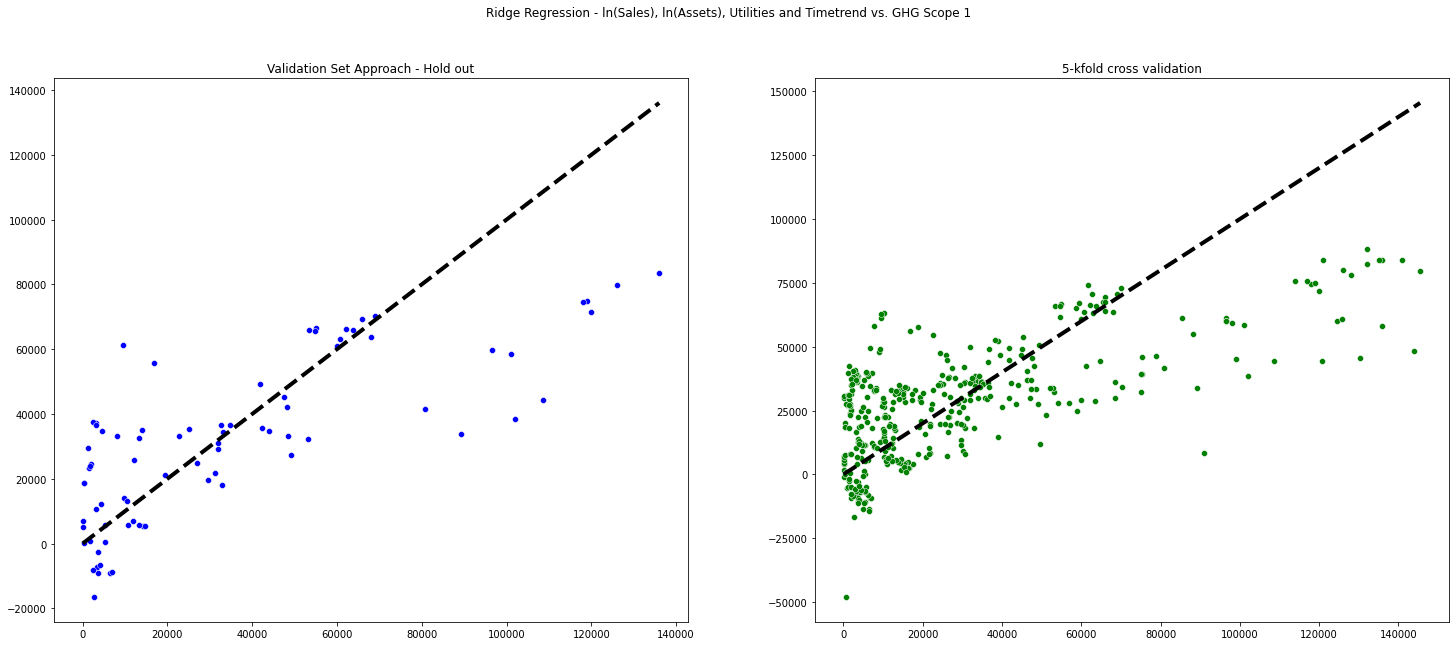

In [515]:
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv.fit(X,y)
ridge_3 = Ridge(alpha = ridgecv.alpha_, normalize = True)
kfold = KFold(n_splits=5, random_state = 42, shuffle=True)
predicted = cross_val_predict(ridge_3, X, y, cv=kfold)

fig, axs = plt.subplots(1,2, figsize=(25,10));
fig.suptitle('Ridge Regression - ln(Sales), ln(Assets), Utilities and Timetrend vs. GHG Scope 1');
sns.scatterplot(x=y_test, y = yhat_ridge, ax=axs[0], color='b');
axs[0].set_title('Validation Set Approach - Hold out');
axs[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4);
sns.scatterplot(x=y, y = predicted, ax=axs[1], color='g');
axs[1].set_title('5-kfold cross validation');
axs[1].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4);

In [516]:
df_model_eval.loc[len(df_model_eval.index)] = [21, 'Ridge (ln(Sales) + ln(Asset) + Utilities + Timetrend)', 'Hold-out',
                                               metrics.mean_squared_error(y_test, yhat_ridge), np.sqrt(metrics.mean_squared_error(y_test, yhat_ridge)), metrics.r2_score(ytest, yhat_ridge)] 
df_model_eval.loc[len(df_model_eval.index)] = [22, 'Ridge (ln(Sales) + ln(Asset) + Utilities + Timetrend)', '5 K-fold',
                                               569315901.59, 23860.34, 0.46] 
df_model_eval.tail()

,Model_Number,Model_Name,Approach,MSE,RMSE,R-Squared
17,18,Lasso (Sales + Asset + Utilities + Timetrend),5 K-fold,458655027.230,21416.230,0.570
18,19,Linear (ln(Sales) + ln(Asset) + Utilities + Ti...,Hold-out,554112883.075,23539.602,0.580
19,20,Linear (ln(Sales) + ln(Asset) + Utilities + Ti...,5 K-fold,458669164.200,21416.560,0.570
20,21,Ridge (ln(Sales) + ln(Asset) + Utilities + Tim...,Hold-out,556491817.079,23590.079,0.578
21,22,Ridge (ln(Sales) + ln(Asset) + Utilities + Tim...,5 K-fold,569315901.590,23860.340,0.460


#### Lasso Regression 

We were unable to improve the model accuracy by using Ridge Regression. Let's give it a try to the Lasso Regression. 


First, we will plot the weights and alphas to see get a better idea of the feature importance. 

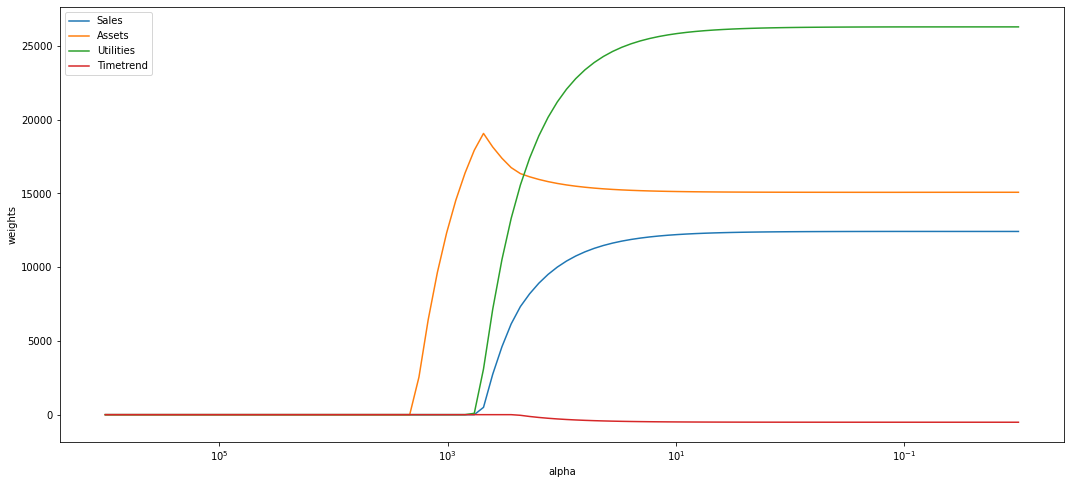

In [517]:
lasso = Lasso(max_iter = 10000, normalize = True)
coefs = []
errors = []
alphas = 10**np.linspace(6,-2,100)*0.5


X=stock[['Logarithm_Total_Sales','Logarithm_Total_Assets','Utility','time_trend']].copy().values
y=stock['GHG Scope 1'].copy().values

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X, y)
    coefs.append(lasso.coef_)
    errors.append(metrics.mean_squared_error(lasso.predict(X), y))

plt.figure(figsize=(18, 8))
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.legend(['Sales', 'Assets','Utilities','Timetrend'])
plt.xlabel('alpha')
plt.ylabel('weights');

Similarly as Ridge regression, Timetrend predictor doesn't seem that important. However, we can see that knowing if the company is utility or not, the assets and sales are more important.

Let's do some fitting and predictions. 

#### Validation set approach

We continue subsetting 80% to train and 20% to test. 

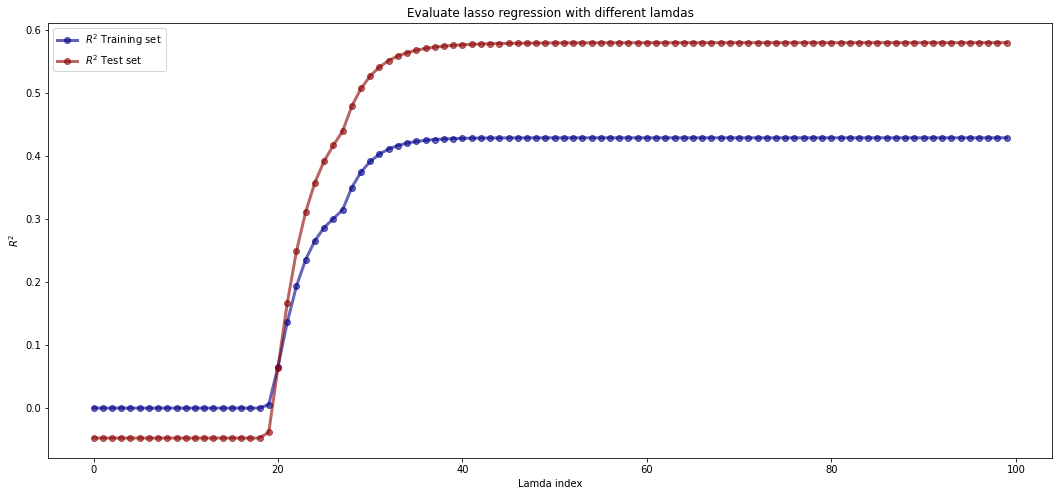

In [518]:
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
l_num = 100
pred_num = X.shape[1]

# prepare data for enumerate
coeff_a = np.zeros((l_num, pred_num))
train_r_squared = np.zeros(l_num)
test_r_squared = np.zeros(l_num)
train_mse = np.zeros(l_num)
test_mse = np.zeros(l_num)

for ind, i in enumerate(alphas):    
    reg = Lasso(alpha = i)
    reg.fit(X_train, y_train)

    coeff_a[ind,:] = reg.coef_
    train_r_squared[ind] = reg.score(X_train, y_train)
    test_r_squared[ind] = reg.score(X_test, y_test)
    train_mse[ind] = metrics.mean_squared_error(reg.predict(X_train), y_train)
    test_mse[ind] = metrics.mean_squared_error(reg.predict(X_test), y_test)

plt.figure(figsize=(18, 8))
plt.plot(train_r_squared, 'bo-', label=r'$R^2$ Training set', color="darkblue", alpha=0.6, linewidth=3)
plt.plot(test_r_squared, 'bo-', label=r'$R^2$ Test set', color="darkred", alpha=0.6, linewidth=3)
plt.xlabel('Lamda index'); plt.ylabel(r'$R^2$')
plt.title('Evaluate lasso regression with different lamdas');
plt.legend(loc='best');

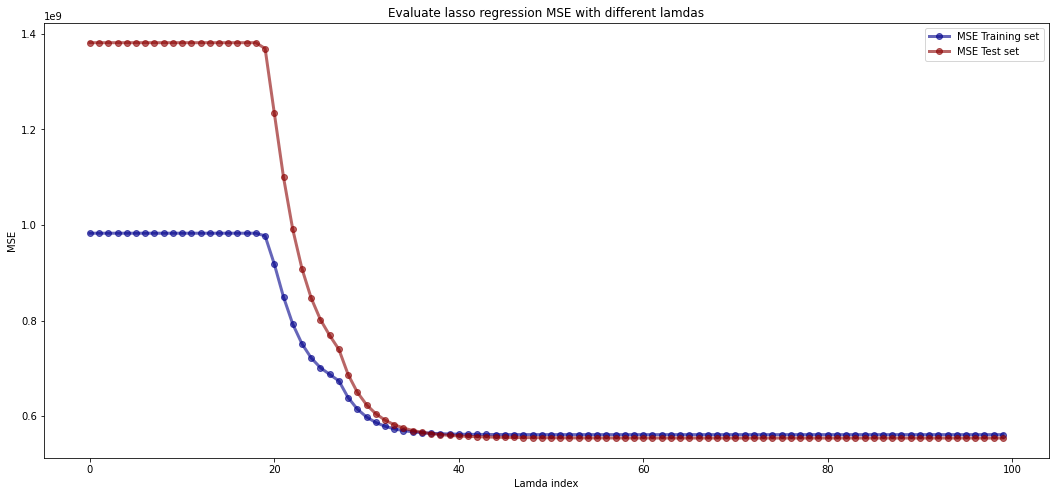

In [519]:
plt.figure(figsize=(18, 8))
plt.plot(train_mse, 'bo-', label=r'MSE Training set', color="darkblue", alpha=0.6, linewidth=3)
plt.plot(test_mse, 'bo-', label=r'MSE Test set', color="darkred", alpha=0.6, linewidth=3)
plt.xlabel('Lamda index'); plt.ylabel(r'MSE')
plt.title('Evaluate lasso regression MSE with different lamdas');
plt.legend(loc='best');

Instead of arbitrarily choosing alpha, we used cross-validation to choose the tuning parameter alpha. 

In [520]:
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassocv.fit(X_train, y_train)

print(f'The optimal alpha is {lassocv.alpha_}')

The optimal alpha is 0.9954718896794494


In [521]:
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
yhat_train = lasso.predict(X_train)
yhat_lasso = lasso.predict(X_test)

# Evaluate the model
print(f'Coefficients \n {lasso.coef_}')
print('Mean squared error: %.2f' % metrics.mean_squared_error(y_test, yhat_lasso))
print(f'Root Mean Squared Error: {np.sqrt(metrics.mean_squared_error(y_test, yhat_lasso))}')
print('Coefficient of determination: %.2f'% metrics.r2_score(y_test, yhat_lasso ))

Coefficients 
 [11853.09422419 14610.23601966 26135.08995171  -628.35981912]
Mean squared error: 554227879.45
Root Mean Squared Error: 23542.044929260162
Coefficient of determination: 0.58


In [522]:
print('MSE train: %.3f, test: %.3f' % (metrics.mean_squared_error(y_train, yhat_train),
                metrics.mean_squared_error(y_test, yhat_lasso)))

MSE train: 561249690.834, test: 554227879.451


Model 3 and 4 present a lower MSE test than MSE Train. Moreover, this model accounts for 58% of the variance. 

We can see lower coefficient estimates, however, none of them were yield closely to zero. We have big coefficients which means variance is high and the model won't behave great with unseen data.  

#### Lasso Regression 

#### K-fold Cross validation approach

Now, we are going to consider different folds to fit and predict while using the best alpha. 

In [523]:
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassocv.fit(X, y)
lasso = Lasso(max_iter = 10000, normalize = True)
lasso.set_params(alpha=lassocv.alpha_)
kfold_cross_validation(5, X, y, lasso)

Mean squared error: 569052802.05
Root Mean Squared Error: 23854.82764669995
Coefficient of determination: 0.46


In [524]:
lasso = Lasso(max_iter = 10000, normalize = True)
lasso.set_params(alpha=lassocv.alpha_)
kfold_cross_validation(10, X, y, lasso)

Mean squared error: 573604329.02
Root Mean Squared Error: 23950.038184050187
Coefficient of determination: 0.46


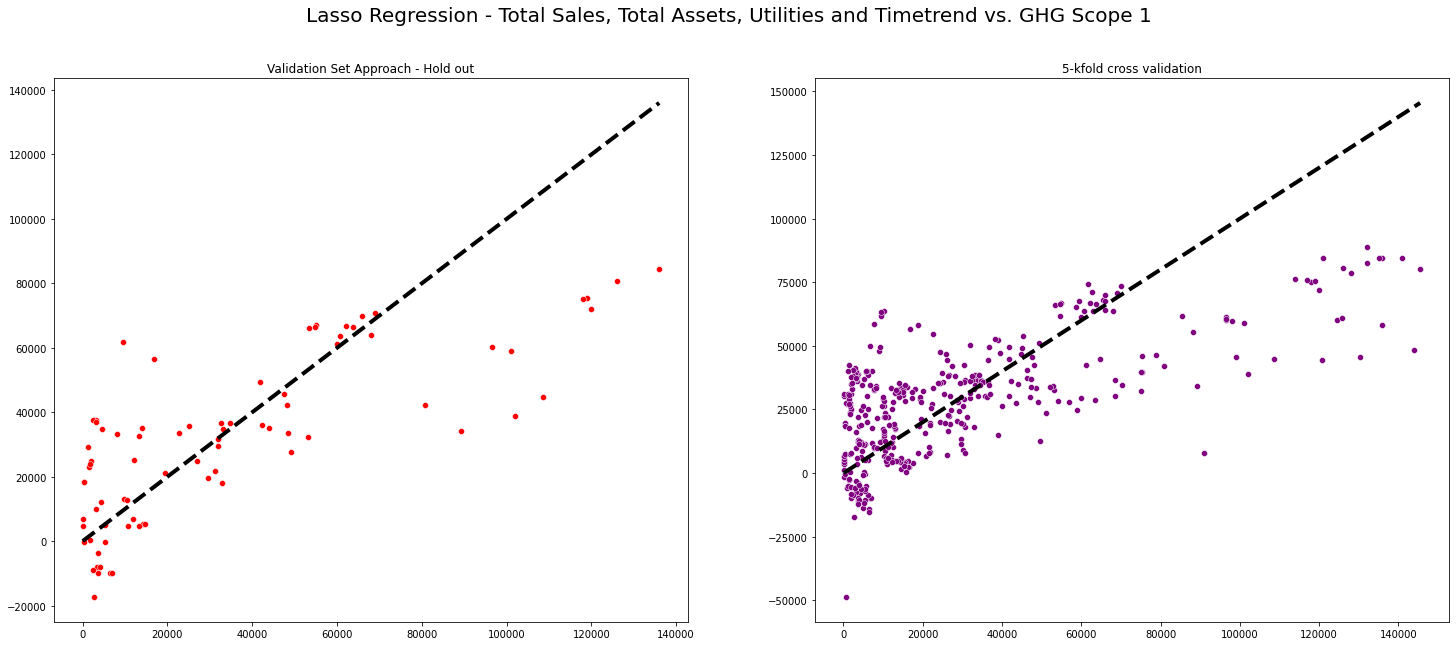

In [525]:
lasso = Lasso(max_iter = 10000, normalize = True)
lasso.set_params(alpha=lassocv.alpha_)
kfold = KFold(n_splits=5, random_state = 42, shuffle=True)
predicted = cross_val_predict(lasso, X, y, cv=kfold)

fig, axs = plt.subplots(1,2, figsize=(25,10));
fig.suptitle('Lasso Regression - Total Sales, Total Assets, Utilities and Timetrend vs. GHG Scope 1', fontsize=20);
sns.scatterplot(x=y_test, y = yhat_lasso, ax=axs[0], color='red');
axs[0].set_title('Validation Set Approach - Hold out');
axs[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4);
sns.scatterplot(x=y, y = predicted, ax=axs[1], color='purple');
axs[1].set_title('5-kfold cross validation');
axs[1].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4);

In [526]:
df_model_eval.loc[len(df_model_eval.index)] = [23, 'Lasso (ln(Sales) + ln(Asset) + Utilities + Timetrend)', 'Hold-out', metrics.mean_squared_error(y_test, yhat_lasso),
                                               np.sqrt(metrics.mean_squared_error(y_test, yhat_lasso)),metrics.r2_score(y_test, yhat_lasso ) ] 
df_model_eval.loc[len(df_model_eval.index)] = [24, 'Lasso (ln(Sales) + ln(Asset) + Utilities + Timetrend)', '5 K-fold', 569052802.05, 23950.03,0.46 ] 
df_model_eval.tail()

,Model_Number,Model_Name,Approach,MSE,RMSE,R-Squared
19,20,Linear (ln(Sales) + ln(Asset) + Utilities + Ti...,5 K-fold,458669164.200,21416.560,0.570
20,21,Ridge (ln(Sales) + ln(Asset) + Utilities + Tim...,Hold-out,556491817.079,23590.079,0.578
21,22,Ridge (ln(Sales) + ln(Asset) + Utilities + Tim...,5 K-fold,569315901.590,23860.340,0.460
22,23,Lasso (ln(Sales) + ln(Asset) + Utilities + Tim...,Hold-out,554227879.451,23542.045,0.580
23,24,Lasso (ln(Sales) + ln(Asset) + Utilities + Tim...,5 K-fold,569052802.050,23950.030,0.460


### Conclusion - Model performance

All four predictive models had a big MSE when predicting the GHG Scope and the main reason for this could be related to the few observations that we have to train the model. 

We need to consider other approaches to increase the models performance such as other ML Techniques (Decision trees, boosting trees, etc). Also, we can consider other features we may want to include to the best performing model. 

In this section, we are going to review all the MSE and talk about each model's performance.

In [527]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(f'After running different regressions and applying several techniques, we concluded with {df_model_eval.shape[0]} MSE to analyze and compare.')

After running different regressions and applying several techniques, we concluded with 24 MSE to analyze and compare.


In [528]:
df_model_eval[['Model_Name','RMSE','R-Squared', 'Approach']]

,Model_Name,RMSE,R-Squared,Approach
0,Linear (Sales + Asset),24420.768,0.548,Hold-out
1,Linear (Sales + Asset),23921.601,0.460,5 K-fold
2,Ridge (Sales + Asset),24366.141,0.550,Hold-out
3,Ridge (Sales + Asset),23974.267,0.460,5 K-fold
4,Lasso (Sales + Assets),24383.723,0.549,Hold-out
5,Lasso (Sales + Assets),23919.950,0.460,5 K-fold
6,Linear (ln(Sales) + ln(Asset)),28215.951,0.396,Hold-out
7,Linear (ln(Sales) + ln(Asset)),26015.180,0.360,5 K-fold
8,Ridge (ln(Sales) + ln(Asset)),25946.186,0.490,Hold-out
9,Ridge (ln(Sales) + ln(Asset)),26016.210,0.360,5 K-fold


We start by plotting the results for the first 3 models, Linear, Ridge and Lasso models trying
to predict GHG Scope by using Sales and Assets. The labels that are on the graphs are for the R-Score and
the bar heights represent the RMSE score.



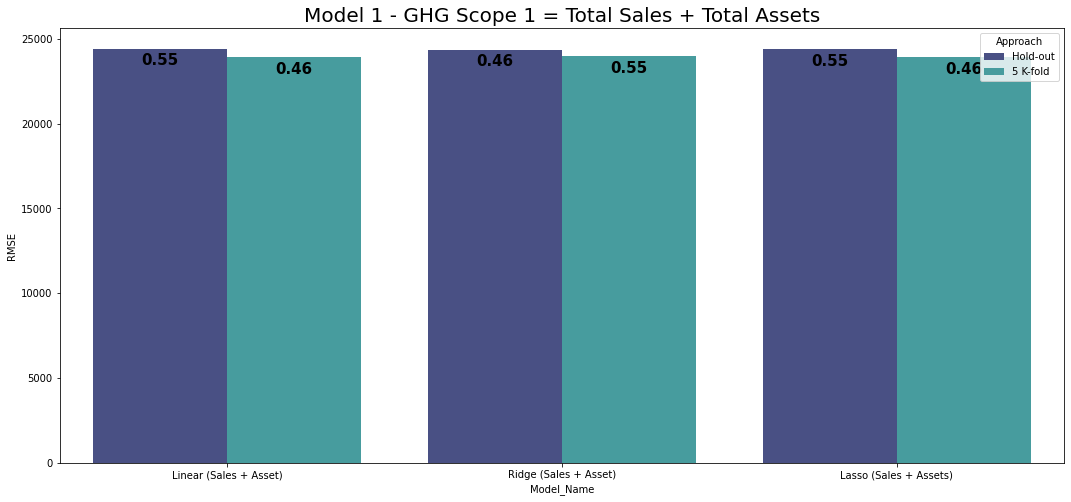

In [540]:
pmodel_1 = df_model_eval[0:6]
plt.figure(figsize=(18, 8))
g = sns.barplot('Model_Name', 'RMSE', hue = 'Approach', data = pmodel_1, palette = 'mako')
g.set_title('Model 1 - GHG Scope 1 = Total Sales + Total Assets', fontsize = 20)
# for item in g.get_xticklabels():
#     item.set_rotation(10)

count = 0
for p in g.patches:
    g.annotate(round(pmodel_1.iloc[count,5:6][0], 2),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   size=15,
                   xytext = (0, -12),
                   textcoords = 'offset points',
                   weight = 'bold')
    count+=1

plt.show()

From the graph above we can see that all of the regressions have similar RMSE scores while ridge regression has the highest
r-score.


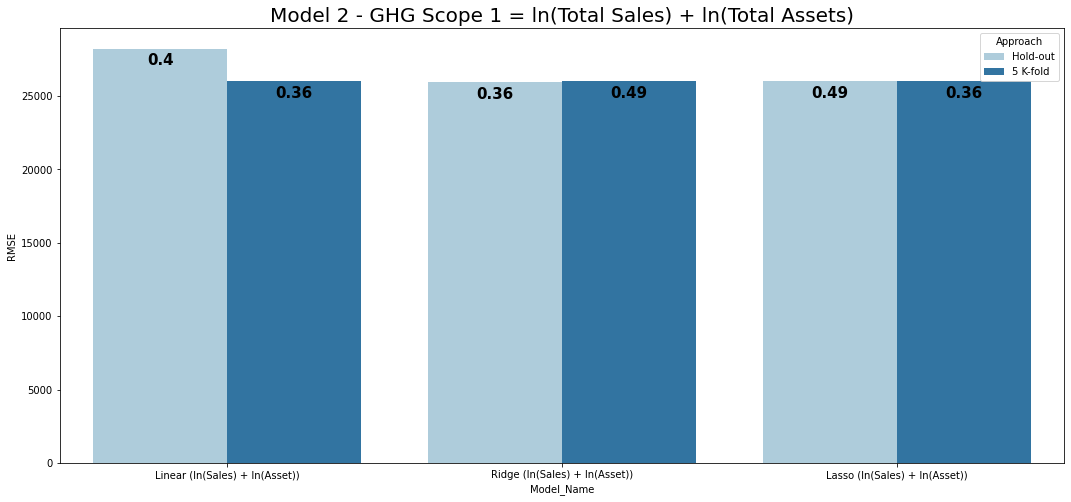

In [541]:
pmodel_2 = df_model_eval[6:12]

plt.figure(figsize=(18, 8))
x = sns.barplot('Model_Name', 'RMSE', hue = 'Approach', data = pmodel_2, palette = 'Paired')
x.set_title('Model 2 - GHG Scope 1 = ln(Total Sales) + ln(Total Assets)', fontsize = 20)

count = 0
for p in x.patches:
    x.annotate(round(pmodel_2.iloc[count,5:6][0], 2), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, -12), 
                   textcoords = 'offset points',
                   weight = 'bold')
    count+=1

The graph above shows that Linear regression on log of Sales and Asset has a higher
 RMSE score, and ridge and lasso also have a higher r-score making them better in predicting the dataset.
 However the rmse is still too high to make correct predictions.

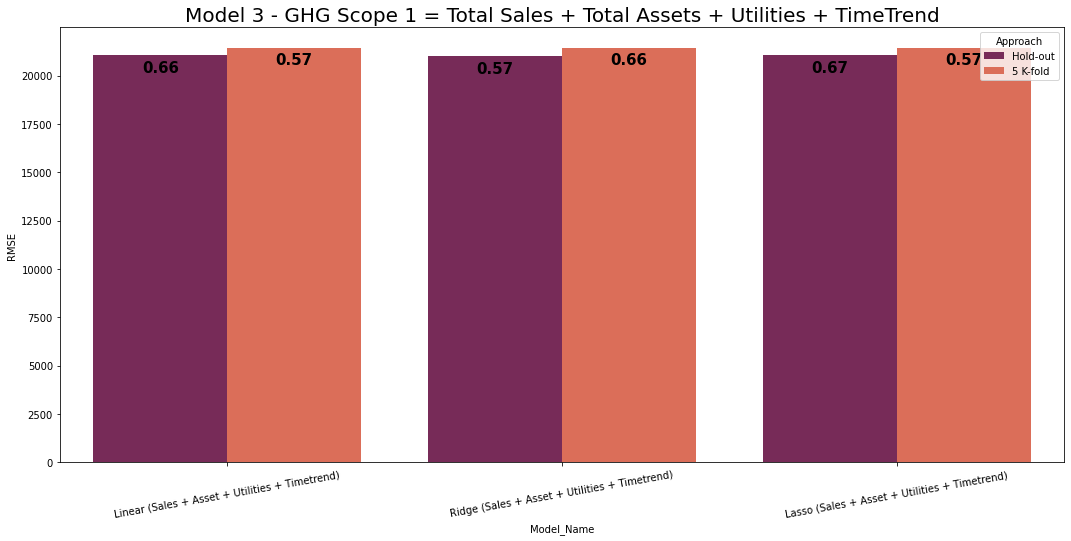

In [542]:
pmodel_3 = df_model_eval[12:18]

plt.figure(figsize=(18, 8))
Z = sns.barplot('Model_Name', 'RMSE', hue = 'Approach', data = pmodel_3, palette = 'rocket')
Z.set_title('Model 3 - GHG Scope 1 = Total Sales + Total Assets + Utilities + TimeTrend', fontsize = 20)
for item in Z.get_xticklabels():
    item.set_rotation(10)

count = 0
for p in Z.patches:
    Z.annotate(round(pmodel_3.iloc[count,5:6][0], 2), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, -12), 
                   textcoords = 'offset points',
                   weight = 'bold')
    count+=1

The graph above shows that adding Timetrend greatly decreases the RMSE,
however not to the levels where we fill comfortable predicting values.

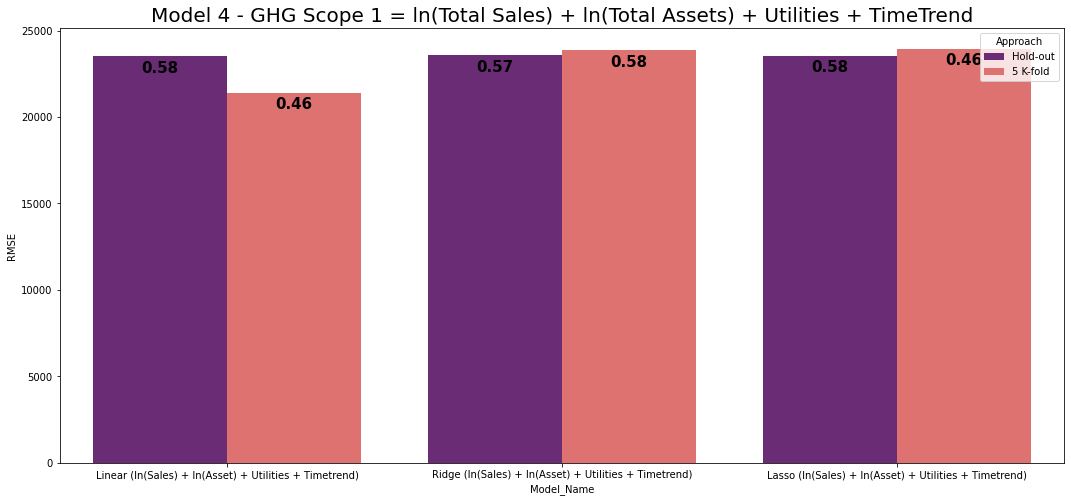

In [543]:
pmodel_4 = df_model_eval[18:24]

plt.figure(figsize=(18, 8))
b = sns.barplot('Model_Name', 'RMSE', hue = 'Approach', data = pmodel_4, palette = 'magma')
b.set_title('Model 4 - GHG Scope 1 = ln(Total Sales) + ln(Total Assets) + Utilities + TimeTrend', fontsize = 20)


count = 0
for p in b.patches:
    b.annotate(round(pmodel_4.iloc[count,5:6][0], 2), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, -12), 
                   textcoords = 'offset points',
                   weight = 'bold')
    count+=1


The graph above shows that taking the log of sales and assets does not help decrease the rmse.

## Conclusion

From the table of RMSE we can see that while adding Timetrend, as well as Sales, and Assets as a predictor variable
decreases RMSE the most it is not to the point where we feel comfortable predicting values for GHG Scope. It seems as
we need more points of observation to be able to accurately predict the values of Green House Gas emissions, we can make
use of external data in order to better predict these numbers.

We will see in the  'Fixed_Effects_Regression' notebook
there is 'Environmental Intensity' data for over four thousand companies, this variable can be used to match directly
with companies in the GHG Scope dataset to produce better results.


Now, we are going to continue our analysis in the 'Fixed_Effects_Regression' notebook.